# Lens modelling of DESJ0408-5354 with multiple options
This notebooks takes the data and psf configurations of the pre-analysis and configures (and runs) the lens modelling and parameter inference.
There are two modes:
    - local execution of a single model: this is mostly to test a model and having an output in a finite time. This is the default setting of this notebook.
    - cluster compute: it sends the configuration files to a cluster where the same models can be executed on multiple cores. This is the mode the results were produced.
    
In the second mode, the notebook initializes all the models that have been included in the analysis of [Shajib et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.6072S/abstract).
In the last blocks of the notebook, some quick model inspections are performed.

### import libraries

In [1]:
import lenstronomy

lenstronomy.__version__

'1.10.2'

In [2]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
from lenstronomy.Util import param_util

from paperfig import *
set_fontscale(2)

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print(base_path)

/Users/ajshajib/Research/time_delay_cosmography/J0408/DESJ0408_time_delay_cosmography


### set up the Data() and PSF() class of lenstronomy

In [3]:
def import_data(filter_name):
    """
    """
    data_file = os.path.join(base_path, 'data', 'data_{}.hdf5'.format(filter_name))
    f = h5py.File(data_file, 'r')
    
    data_reduced = f['image_data'][()]
    background_rms = f['background_rms'][()]
    exposure_map = f['exposure_map'][()]
    ra_at_xy_0 = f['ra_at_xy_0'][()]
    dec_at_xy_0 = f['dec_at_xy_0'][()]
    
    transform_pix2angle = f['transform_pix2angle'][()]
    f.close()

    kwargs_data = {'image_data': data_reduced, 
                    'background_rms': background_rms,
                    'noise_map': None,
                    'exposure_time': exposure_map,
                    'ra_at_xy_0': ra_at_xy_0,
                    'dec_at_xy_0': dec_at_xy_0, 
                    'transform_pix2angle': transform_pix2angle
                    }

    # get data and PSF estimate from file
    psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
    psf_error_map = f['psf_error_map'][()]
    f.close()


    kwargs_psf = {'psf_type': "PIXEL", 
                   'kernel_point_source': kernel_point_source ,
                   'kernel_point_source_init': kernel_point_source ,
                   'psf_error_map': psf_error_map,
                   #'psf_error_map_init': psf_error_map,
                   #'block_neighbour': 1.13/2.
                   }
    
    return kwargs_data, kwargs_psf

kwargs_data_f160w, kwargs_psf_f160w = import_data('f160w')
kwargs_data_f814w, kwargs_psf_f814w = import_data('f814w')
kwargs_data_f475x, kwargs_psf_f475x = import_data('f475x')

# putting in some offsets to align IR an UVIS bands. The alignment will be refined later, but these prior values
# lead to faster convergence.
kwargs_data_f160w['ra_shift'], kwargs_data_f160w['dec_shift'] = 0.15674817, 0.05241063

## show image and initial guesses of point source coordinates

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/4207755599.py:14: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-3, vmax=1)


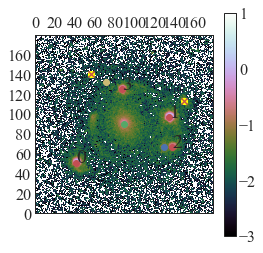

In [4]:
#%matplotlib notebook
%matplotlib inline

# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_f814w['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_f814w['dec_at_xy_0']
transform_pix2angle = kwargs_data_f814w['transform_pix2angle']
coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
data_cutout = kwargs_data_f814w['image_data']
num_pix = len(data_cutout)

plt.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-3, vmax=1)
plt.autoscale(False)

# estimate point source positions in (ra/dec)
im_pos_ra = np.array([ 1.94475366, -1.81367715, -1.92897542,  0.10549876])
im_pos_dec = np.array([-1.57175448,  0.27298662, -0.94625412,  1.38784396])


lens_center_ra, lens_center_dec = 0.0291893810808, -0.00325263009349

# set the luminous satellite position
ra_sat, dec_sat = -1.58267456535, -0.942713265202

# set the perturber galaxy central positions
ra_pert = [] 
dec_pert = []

additional_source_ra = np.array([-2.42, -2.42, 1.35, 1.35])
additional_source_dec = np.array([0.91, 0.91, 2., 2.])

# flux values (arbitrary units) of the perturber galaxies (this has been estimated independently on the HST images)
flux_pert = []

x_sat, y_sat = coords.map_coord2pix(ra_sat, dec_sat)

plt.plot(x_sat, y_sat, 'ob')

for r, d in zip(additional_source_ra, additional_source_dec):
    a, b = coords.map_coord2pix(r, d)
    #print(a, b)
    plt.plot(a, b, 'o', c='yellow')

for s_ra, s_dec in zip(additional_source_ra, additional_source_dec):
    x_source_img, y_source_img = coords.map_coord2pix(s_ra, s_dec)
    plt.plot(x_source_img, y_source_img, 'xr')

x_at_radec_0, y_at_radec_0 = coords.map_coord2pix(0, 0)
x_image, y_image = coords.map_coord2pix(im_pos_ra, im_pos_dec)

plt.plot(x_image, y_image, 'or')

for i in range(len(x_image)):
    plt.text(x_image[i], y_image[i], i, fontsize=20)
    
dp_x, dp_y = coords.map_coord2pix((im_pos_ra[-1]+additional_source_ra[-1])/2., (im_pos_dec[-1]+additional_source_dec[-1])/2.)
plt.plot(dp_x, dp_y, 'oy', markersize=6)
plt.plot(x_at_radec_0, y_at_radec_0, 'og')    
plt.colorbar()
plt.show()

Pixel size in UVIS: 0.040011089527397126 arcsec


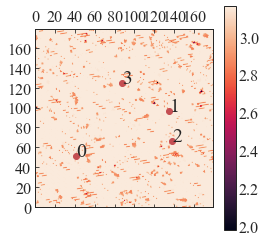

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/114631192.py:19: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(psf_kernel), vmin=-6, cmap=msh_cmap)


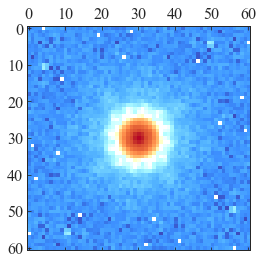

In [5]:
%matplotlib inline 

delta_pix = coords.pixel_width
print('Pixel size in UVIS:', delta_pix, 'arcsec')
x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)
wht_map = kwargs_data_f814w['exposure_time']

plt.matshow(np.log10(wht_map), origin='lower') #, cmap=msh_cmap)
plt.autoscale(False)

plt.plot(x_image,y_image,'or')
for i in range(len(x_image)):
    plt.text(x_image[i], y_image[i], i, fontsize=20)
plt.colorbar()
plt.show()


psf_kernel = kwargs_psf_f814w['kernel_point_source']
plt.matshow(np.log10(psf_kernel), vmin=-6, cmap=msh_cmap)
plt.show()

### set the two masking regions used in the analysis

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/1623433330.py:46: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image), origin='lower', cmap=cmap, vmax=2, vmin=-4)
/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/1623433330.py:57: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=2, vmin=-4)
/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/1623433330.py:57: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=2, vmin=-4)


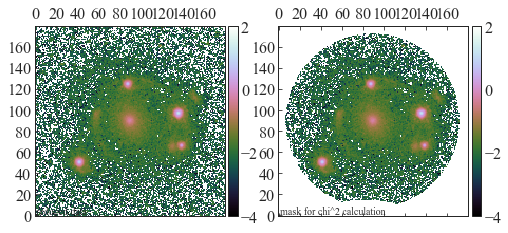

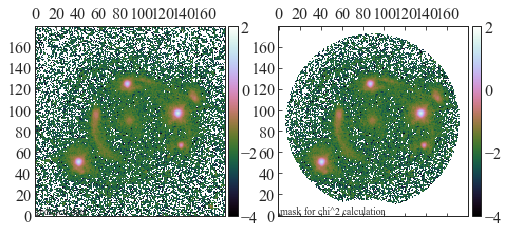

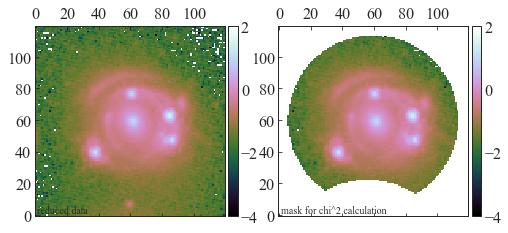

In [6]:
r_mask_list = [
    [3.3], #, 3.2] # f814w
    [3.3], # f475x
    [4.3], # f160w
]

mask_list = []
index_mask_list = []

for i in range(len(r_mask_list[0])):
    mask_bands = []
    index_mask_bands = []

    for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
        num_pix = len(kwargs_data['image_data'])

        x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)
        
        r = r_mask_list[j][i]
        
        mask_outer = mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r, util.image2array(x_coords), util.image2array(y_coords))
        index_mask = 1 - mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r+0.3, util.image2array(x_coords), util.image2array(y_coords))
        
        mask_ext1 = 1 - mask_util.mask_center_2d(lens_center_ra+0.2, lens_center_dec-4.3, 1., util.image2array(x_coords), util.image2array(y_coords))
        mask_ext2 = 1 - mask_util.mask_center_2d(lens_center_ra+0.3, lens_center_dec-7.4, 4.4, util.image2array(x_coords), util.image2array(y_coords))
        mask = (1 - mask_outer) * (1- mask_ext1) * (1 - mask_ext2)
        mask[mask >= 1] = 1
        mask[mask < 0] = 0
        
        mask_bands.append(array2image(mask))
        index_mask_bands.append(array2image(index_mask))
        
    mask_list.append(mask_bands)
    index_mask_list.append(index_mask_bands)

for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
    image = kwargs_data['image_data']
    
    f, axes = plt.subplots(1, len(r_mask_list[j])+1, figsize=(8, 4), sharex=False, sharey=False)
    
    ax = axes[0]
    im = ax.matshow(np.log10(image), origin='lower', cmap=cmap, vmax=2, vmin=-4)
    ax.text(1, 1, 'reduced data')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
        
    for i in range(len(mask_list)):
        ax = axes[i+1]
        
        mask = mask_list[i][j]
        im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=2, vmin=-4)
        ax.text(1, 1, 'mask for chi^2 calculation')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.show()

## supersampling mask

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/3577052619.py:20: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower')


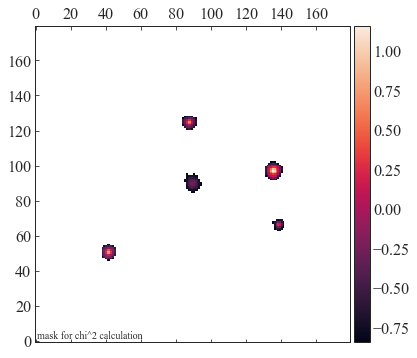

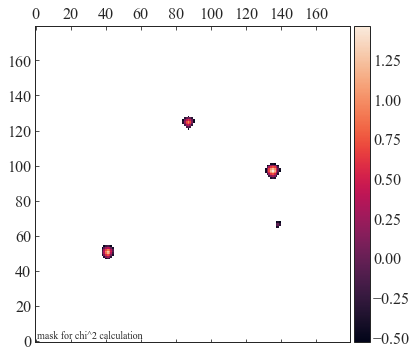

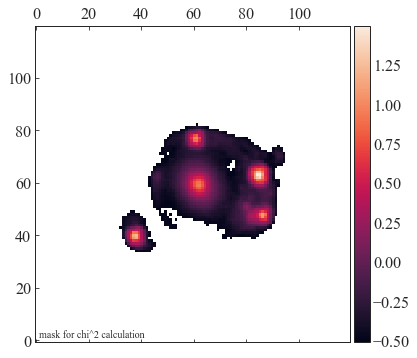

In [7]:
threshold = 10**(5/2.5) # pixels with flux > max_flux/threshold will not be supersampled

supersampling_mask = []

for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
    s_mask = np.ones_like(kwargs_data['image_data'])
    
    max_flux = np.max(kwargs_data['image_data'])
    s_mask[kwargs_data['image_data'] < max_flux/threshold] = 0
    
    supersampling_mask.append(s_mask)

for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
    image = kwargs_data['image_data']
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    mask = supersampling_mask[j]*mask_list[0][j]
    im = ax.matshow(np.log10(image*mask), origin='lower')
    ax.text(1, 1, 'mask for chi^2 calculation')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    plt.show()

## Source planes

In [8]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05) # define cosmology 
# wCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ode0=0.7, Ob0=0.05, w0=-1.5) 

z_l = 0.597

# Dominique and Lise claim 2.27 for the qso and 2.35 for the other blob.
z_s1 = 2.375
z_s2 = 2.228 #np.linspace(2.13, 2.42, 20)
z_s3 = 2.375 # keeping it same as z_s1

D_s1 = cosmo.angular_diameter_distance(z_s1).value
D_s2 = cosmo.angular_diameter_distance(z_s2).value
D_ls1 = cosmo.angular_diameter_distance_z1z2(z_l, z_s1).value
D_ls2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s2).value

c = D_s2 * D_ls1 / D_s1 / D_ls2

print('deflection angle rescale factor: {:.6f}'.format(c))

deflection angle rescale factor: 1.021806


In [9]:
ssh_command = 'ajshajib@hoffman2.idre.ucla.edu'
dir_path = os.getcwd()
dir_path_cluster = '/u/flashscratch/a/ajshajib/'

# Set up all the priors

/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

Rs peaks: [6.91067018 3.00663403 5.38850783]


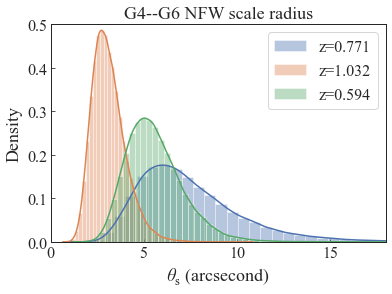

In [10]:
Rs_prior = np.loadtxt('../data/theta_s_prior.npy')

zs = [0.771, 1.032, 0.594]

for n in range(3):
    sns.distplot(Rs_prior[n], label='z={:.3f}'.format(zs[n]))
    
plt.xlabel(r'$\theta_{\rm s}$ (arcsecond)')
plt.xlim(0, 18.)
plt.ylim(0, 0.5)
plt.title('G4--G6 NFW scale radius')
plt.legend();
 
Rs_prior_max_list = [18., 9., 14.] # G4--G6

Rs_ml_list = np.median(Rs_prior, axis=1)

print('Rs peaks:', Rs_ml_list)

/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

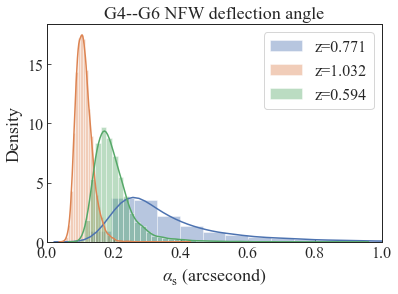

In [11]:
alpha_s_prior = np.loadtxt('../data/alpha_s_distribution.npy')

for n in range(3):
    sns.distplot(alpha_s_prior[n], label='z={:.3f}'.format(zs[n]))
    
plt.xlim(0, 1)
plt.xlabel(r'$\alpha_{\rm s}$ (arcsecond)')
plt.title('G4--G6 NFW deflection angle')
plt.legend()
plt.show()

/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

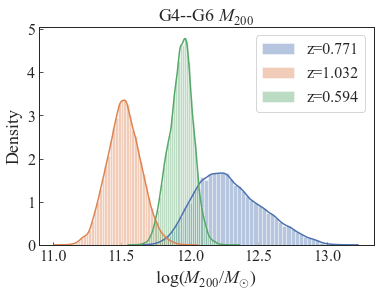

In [12]:
M200_prior = np.loadtxt('../data/logM200_prior.npy')

for n in range(3):
    sns.distplot(M200_prior[n], label='z={:.3f}'.format(zs[n]))
    
#plt.xlim(0, 1)
plt.xlabel(r'$\log (M_{\rm 200}/M_{\odot})$')
plt.title(r'G4--G6 $M_{200}$')
plt.legend()
plt.show()

M200_up_lims = [13.4, 12.3, 12.5]
M200_low_lims = [11.3, 10.8, 11.4]
M200_est = np.median(M200_prior, axis=1)


/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

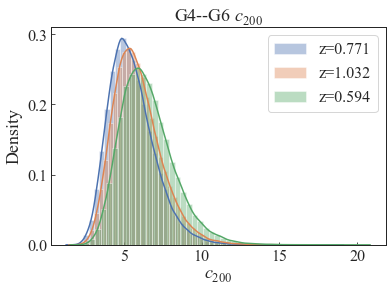

In [13]:
c200_prior = np.loadtxt('../data/c_prior.npy')

for n in range(3):
    sns.distplot(c200_prior[n], label='z={:.3f}'.format(zs[n]))
    
#plt.xlim(0, 1)
plt.xlabel(r'$c_{200}$')
plt.title(r'G4--G6 $c_{200}$')
plt.legend()
plt.show()

c200_up_lims = [16., 16.5, 20.]
c200_low_lims = [0., 0., 0.]
c200_est = np.median(c200_prior, axis=1)


/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/1605199649.py:2: RuntimeWarning: divide by zero encountered in log
  return np.exp(-(np.log(x)-mu)**2/2./sigma**2) / np.sqrt(2.*np.pi) / x / np.abs(sigma)
/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/1605199649.py:2: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(-(np.log(x)-mu)**2/2./sigma**2) / np.sqrt(2.*np.pi) / x / np.abs(sigma)
/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/1605199649.py:2: RuntimeWarning: divide by zero encountered in log
  return np.exp(-(np.log(x)-mu)**2/2./sigma**2) / np.sqrt(2.*np.pi) / x / np.abs(sigma)
/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/1605199649.py:2: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(-(np.log(x)-mu)**2/2./sigma**2) / np.sqrt(2.*np.pi) / x / np.abs(sigma)
/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/1605199649.py:2: RuntimeWarning: divide b

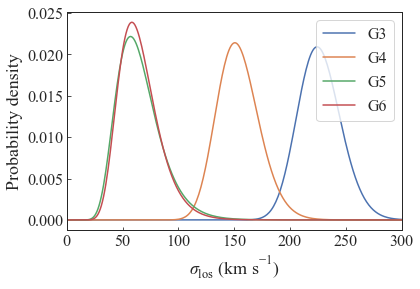

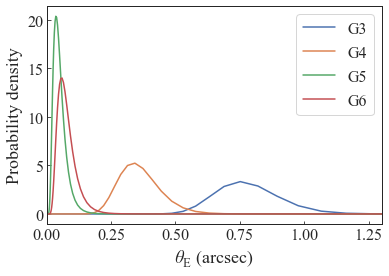

In [14]:
def lognormal(x, mu, sigma):
    return np.exp(-(np.log(x)-mu)**2/2./sigma**2) / np.sqrt(2.*np.pi) / x / np.abs(sigma)

def normal(x, mu, sigma):
    return np.exp(-(x-mu)**2/2./sigma**2) / np.sqrt(2*np.pi) / sigma

vel_dis = np.array([226., 153., 56.*np.sqrt(2.5/2.), 63.])
vel_dis_sig = np.array([20, 20., 22., 20.])

z_perturbers = [0.769, 0.771, 1.032, 0.594]
                          
D_ps = np.array([cosmo.angular_diameter_distance_z1z2(z, z_s1).value for z in z_perturbers])
D_s1 = cosmo.angular_diameter_distance(z_s1).value                

theta_e_prior_mu = 4*np.pi * (vel_dis / 299792.458)**2 * D_ps / D_s1 * 206265.
theta_e_prior_high = 4*np.pi * ((vel_dis+3.*vel_dis_sig)/ 299792.458)**2 * D_ps / D_s1 * 206265.

theta_e_prior_mu_gauss = theta_e_prior_mu
theta_e_prior_sig_gauss = (theta_e_prior_high - theta_e_prior_mu)/3.

theta_e_prior_sig = np.log((theta_e_prior_high/theta_e_prior_mu)**(1/3.))
theta_e_prior_mu = np.log(theta_e_prior_mu)

xs = np.linspace(0, 400, 400)
labels=['G3', 'G4', 'G5', 'G6']

for vd_mu, vd_sig, l in zip(np.log(vel_dis), np.log((vel_dis+vel_dis_sig)/vel_dis), labels):
    plt.plot(xs, lognormal(xs, vd_mu, vd_sig), label=l)

plt.xlabel(r'$\sigma_{\rm los}$ (km s$^{-1}$)')
plt.ylabel('Probability density')
plt.legend()
plt.xlim(0, 300)
    
plt.show()

xs = np.logspace(-3.5, np.log10(1.8), 100) 

for t_mu, t_sig, l in zip(theta_e_prior_mu, theta_e_prior_sig, labels):
    plt.plot(xs, (lognormal(xs, t_mu, t_sig)), label=l)
    
plt.xlabel(r'$\theta_{\rm E}$ (arcsec)')
plt.ylabel('Probability density')
plt.legend()
    
plt.xlim(0, 1.3)
plt.show()
    
theta_e_perturber_up = np.array([1.6, 0.97, 0.2, 0.3])
theta_e_perturber_low = np.array([.3, 5e-4, 5e-4, 5e-4])

### S2's $\theta_{\rm E}$ prior

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/1411059185.py:2: RuntimeWarning: divide by zero encountered in log
  return np.exp(-(np.log(x)-mu)**2/2./sigma**2) / np.sqrt(2.*np.pi) / x / np.abs(sigma)
/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/1411059185.py:2: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(-(np.log(x)-mu)**2/2./sigma**2) / np.sqrt(2.*np.pi) / x / np.abs(sigma)


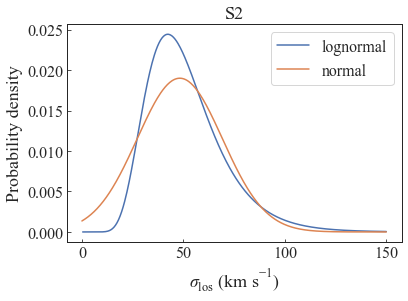

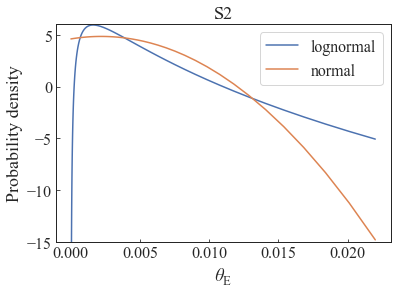

In [15]:
def lognormal(x, mu, sigma):
    return np.exp(-(np.log(x)-mu)**2/2./sigma**2) / np.sqrt(2.*np.pi) / x / np.abs(sigma)

s2_vel_dis = 46. * np.sqrt(2.2/2.)
s2_vel_dis_sig = 21.

s2_z = 2.228
                          
D_s2s = cosmo.angular_diameter_distance_z1z2(s2_z, z_s1).value
D_s1 = cosmo.angular_diameter_distance(z_s1).value                

s2_theta_e_prior_mu = 4*np.pi * (s2_vel_dis / 299792.458)**2 * D_s2s / D_s1 * 206265.
s2_theta_e_prior_high = 4*np.pi * ((s2_vel_dis+3*s2_vel_dis_sig)/ 299792.458)**2 * D_s2s / D_s1 * 206265.

s2_theta_e_prior_mu_gauss = s2_theta_e_prior_mu
s2_theta_e_prior_sig_gauss = (s2_theta_e_prior_high - s2_theta_e_prior_mu)/3.

s2_theta_e_prior_sig = np.log((s2_theta_e_prior_high/s2_theta_e_prior_mu)**(1/3.))
s2_theta_e_prior_mu = np.log(s2_theta_e_prior_mu)

# print(s2_theta_e_prior_mu, s2_theta_e_prior_sig)
# print(s2_theta_e_prior_mu_gauss, s2_theta_e_prior_sig_gauss)

xs = np.linspace(0, 150, 400)

plt.plot(xs, lognormal(xs, np.log(s2_vel_dis), np.log((s2_vel_dis+s2_vel_dis_sig)/s2_vel_dis)), label='lognormal')
plt.plot(xs, normal(xs, s2_vel_dis, s2_vel_dis_sig), label='normal')
plt.xlabel(r'$\sigma_{\rm los}$ (km s$^{-1}$)')
plt.ylabel('Probability density')
plt.title('S2')
plt.legend()
plt.show()

xs = np.logspace(-5.5, np.log10(.022), 100) 

plt.plot(xs, np.log(lognormal(xs, s2_theta_e_prior_mu, s2_theta_e_prior_sig)), label='lognormal')
plt.plot(xs, np.log(normal(xs, s2_theta_e_prior_mu_gauss, s2_theta_e_prior_sig_gauss)), label='normal')
#plt.yscale('log')
plt.ylim(-15, 6)
plt.xlabel(r'$\theta_{\rm E}$')
plt.ylabel('Probability density')
plt.title('S2')
plt.legend()
#plt.xscale('log')
#plt.ylim(0)
plt.show()
    
# print(np.exp(s2_theta_e_prior_mu)*np.exp(s2_theta_e_prior_sig)**4.)
# print()
# print( np.sqrt(0.03 /(4*np.pi * D_s2s / D_s1 * 206265))*299792.458)
# print(4*np.pi * ((s2_vel_dis+5*s2_vel_dis_sig) / 299792.458)**2 * D_s2s / D_s1 * 206265.)
s2_theta_low = 10**(-5.5)
s2_theta_high = 0.022
#theta_e_perturber_up = np.array([2.2, 0.8, 0.2, 0.3])
#theta_e_perturber_low = np.array([1.2, 0., 5e-4, 5e-4])

## G1's r_eff prior

/Users/ajshajib/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


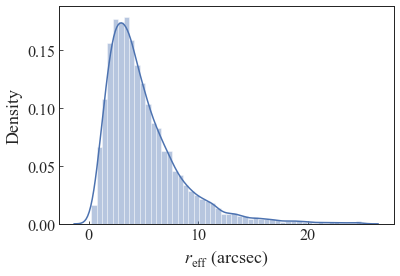

In [16]:
r_eff_phys = np.loadtxt('../data/r_eff_kpc.npy')

sns.distplot(r_eff_phys)
plt.xlabel(r'$r_{\rm eff}$ (arcsec)');
plt.show();

D_A = cosmo.angular_diameter_distance(0.597).value * 1e3

r_eff_prior = r_eff_phys / D_A * 206265. * np.random.normal(loc=1., scale=0.1, size=len(r_eff_phys))

r_eff_prior_mu = np.median(np.log(r_eff_prior))
r_eff_prior_sigma = np.std(np.log(r_eff_prior))

## R_s prior

In [17]:
D_d_nfw = cosmo.angular_diameter_distance(z_l).value


r_s_prior_mu = 58./.7 / D_d_nfw*1e-3 * 206265.
r_s_prior_sigma = 8./.7 / D_d_nfw*1e-3 * 206265.

print(r_s_prior_mu, r_s_prior_sigma)
print(r_s_prior_mu-4*r_s_prior_sigma)
print(r_s_prior_mu+4*r_s_prior_sigma)

12.42248287253445 1.7134459134530282
5.568699218722338
19.276266526346564


# Model options for lenstronomy
- mask_list (larger, smaller): 2
- perturber lens model (SIS, SIE, NFW): 3
- source description (double Sersic, + n_max=2, +n_max=5, +n_max=8): 4
- foreground shear (False, True): 2

## configure job

In [58]:
kwargs_result_old

{'kwargs_lens': [{'theta_E': 1.794928277133542,
   'gamma': 1.7457916574073091,
   'e1': -0.08181057635421232,
   'e2': 0.18872061788801045,
   'center_x': -0.012558474540453123,
   'center_y': -0.1541855040629432},
  {'gamma_ext': 0.05893278393815402,
   'psi_ext': 1.0426260503036155,
   'ra_0': 0,
   'dec_0': 0},
  {'theta_E': 0.15441245400283363,
   'center_x': -1.5784457823921965,
   'center_y': -0.9478411808067807},
  {'theta_E': 0.40616563835745867,
   'center_x': 1.0839901104658902,
   'center_y': -6.516121582054507},
  {'theta_E': 0.10144687506614838,
   'center_x': -0.39902264938181325,
   'center_y': -13.577953376770608},
  {'theta_E': -0.17995458602883774,
   'center_x': 5.342383555962899,
   'center_y': -0.7750999830473467},
  {'theta_E': 0.2962156279762601,
   'center_x': 10.900788854734145,
   'center_y': 5.532826990356399},
  {'theta_E': -0.00033396631272993087,
   'center_x': -0.3241539154260955,
   'center_y': -0.41026490166902974}],
 'kwargs_source': [{'amp': 1,
   'R

In [73]:
import pickle
import joblib

with open('known_solution.pickle', 'rb') as f:
    kwargs_result_old = pickle.load(f)
    
initiate_from_old_result = kwargs_result_old # or None

use_good_start = False # start from a known good pointf
use_good_psf = False
power_law_good_start = '0408_run15_0_0_0_0_0_1_1_0'
#composite_good_start = '0408_run56_0_0_0_0_0_0_0_0'
reconstruct_psf = True
band_number = 3
do_mcmc = False

psf_iteration = True # bool, we perform an iterative PSF reconstruction
psf_iter_num = 200 # number of steps in the PSF reconstruction
psf_iter_factor = 0.5 # factor of f* new + (1-f)* old PSF in each iterative step
psf_symmetry = 4 # number of symmetry axis rotations

n_p_short = 30 # number of particles in the PSO (for tests)
n_i_short = 20 # number of iterations of the PSO (for tests)
n_p_medium = 20*2 # number of particles in the PSO 
n_i_medium = 50 # number of iterations of the PSO 
n_p_long = 20*4 # number of particles in the PSO 
n_i_long = 200 #50 # number of iterations of the PSO 

mcmc_n_burn = 0
mcmc_n_run = 500
walker_ratio = 4

# lens model settings
lens_bound = 0.02 # bound for lens position from the initial position # 07/18 0.24
shear = True  # adding of a external shear component in the model
flexion = False  # addition of explicit flextion terms in the model
with_satellite = True  # adding satellite galaxies in the model
satellite_bound = 0.02 # bound for satellite position from the initial position # 07/18 0.2
satellite_model = 'SIS'

group_halo = False  # additon an additonal group halo in addition to the main deflector
composite_type = 'DOUBLE_CHAMELEON'  # 'CHAMELEON', 'MGE', 'INTERPOL', 'DOUBLE_CHAMELEON'
mass_light_joint = True  # joint mass and light parameters in the composite model option

deflector_redshift = 0.597
source_redshift = 2.375

# perturbers
num_perturber = 4
params_perturber = [{'e1': 0.2450621877437565, 'e2': 0.03714667607931794, 'center_x': 1.0839901104658902, 'center_y': -6.516121582054507},
                    {'e1': -0.028890017349296807, 'e2': -0.028158977487724564, 'center_x': -0.39902264938181325, 'center_y': -13.577953376770608},
                    {'e1': -0.2340480025238654, 'e2': 0.36491989885533666, 'center_x': 5.342383555962899, 'center_y': -0.7750999830473467},
                    {'e1': 0.024375589533094925, 'e2': -0.022563920598150808, 'center_x': 10.900788854734145, 'center_y': 5.532826990356399}]

flux_perturber = np.array([1182.2060558513258, 124.4637138976741, 96.9590378075421, 116.96053693674814]) # total fluxes of perturbers in F160W
perturber_redshift = np.array([0.769, 0.771, 1.032, 0.594])

#mass_scaling = True  # keep mass scaling fixed for external perturbers
mass_light_scatter_dex = 0.1  # scatter in the M/L ratio of the external perturbers
perturber_mass_scaling = [1, 2, 2, 2] # grouping perturber mass scaling
perturber_mass_profile_sis_fix = [True, False, False, False] # which perturber mass profile to fix at SIS regardless of choice

do_multi_lens_plane = True # flag to turn multi-lens-plane ray shooting on/off
set_true_perturber_redshift = [do_multi_lens_plane, False, False, False] # flag to assign true or deflector redshift to perturbers
set_perturber_multi_lens_plane = [do_multi_lens_plane, False, False, False] # flag to set which perturbers at multi-lens plane

# lens light settings
power_law_light = [['SERSIC_ELLIPSE'], #, 'UNIFORM'], 
                   ['SERSIC_ELLIPSE'], #, 'UNIFORM'],
                   ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']] #, 'UNIFORM']]
composite_light = [['SERSIC_ELLIPSE'], 
                   ['SERSIC_ELLIPSE'],
                   ['DOUBLE_CHAMELEON']]
satellite_light = 'SERSIC'

cham_kwargs = [{'amp': 157.478950588284,
                'w_c': 0.630772650765,
                'w_t': 0.001000000000000012,
                'e1': -0.07536215821661636,
                'e2': 0.09437501375063316,
                'center_x': 0.02856867456114267,
                'center_y': -0.002638776274241725},
               {'amp': 10.721364121523639,
                'w_c': 1.777992131293443,
                'w_t': 1.7779921312933415,
                'e1': -0.053286548141704144,
                'e2': 0.1538749371714646,
                'center_x': 0.029290486822256552,
                'center_y': -0.003372700666705117}]

# source light settings
source_light_model_list_template = ['SERSIC_ELLIPSE']  # don't need to add shapelets here, as it's added inside the function
with_shapelets = True
shapelet_beta = 0.285 # initial guess of the shapelet scale (in arcsec)

with_additional_sources = True
additional_source_model = ['SERSIC_ELLIPSE', 'SHAPELETS', 'SERSIC_ELLIPSE']
additional_source_scaling_options = [[c, c, 1, ], [c, c, c]]
additional_source_redshift_options = [[z_s2, z_s2, z_s3], [z_s2, z_s2, z_s2]]
source_bound = 0.24 # bound for additional source position # 07/18 0.16

# point source settings
point_source_model_list = ['LENSED_POSITION']  # we model the point sources in the image plane
ps_bound = 0.01 #8/17 0.005 # 8/12 0.012 8/1 0.008 # bound for point source position # 07/18 0.08 , 7/27 0.03

ml_random_draw = []

def configure_model(job_name, 
                    deflector_id=0, 
                    perturber_model_id=0, 
                    source_redshift_id=0,
                    n_max_id=0,
                    mask=mask_list[0],
                    subgrid_res=3,
                    dark_perturber_option=0,
                    mass_scaling_option=0,
                    s2_mass_option=0,
                    group_halo=False, cluster_compute=True, verbose=False, cluster="hoffman2",
                    initiate_from_old_result=initiate_from_old_result
                   ):
    """
    this definitons takes as an input some specific options that are varried in the modelling and merges them
    with the other choices made and runs the modeling and parameter inference
    
    job_name: string, the file with its specific configuration will be named that way
    lens_model: string: 'composite', 'PEMD' as options
    perturber_model: string, type of model for the perturbers ('SIS', 'SIE', 'NFW', ...)
    mask: 2d numpy array, masking region of fit
    n_max: maximal polynomial order of shapelets in the source plane
    foreground_shear: bool, if True, adds a foreground shear model
    subgrid_res: subsampling of the surface brightness of pixels
    num_perturber: integer, number of perturbers being modeled (in subsequent order of the defined list above)
    group_halo: bool, additon an additonal group halo in addition to the main deflector
    cluser_compute: bool, if True, instead of running the chain, saves and copies the configuration files to a cluster
    """
    global with_shapelets, ml_random_draw
    
    dir_path = os.getcwd()
    if cluster == "hoffman2":
        ssh_command = 'ajshajib@hoffman2.idre.ucla.edu'
        dir_path_cluster = '/u/flashscratch/a/ajshajib/' 
    
    if dark_perturber_option == 1:
        with_dark_perturber = True
    else:
        with_dark_perturber = False
        
    if mass_scaling_option == 0:
        mass_scaling = True
    else:
        mass_scaling = False
        
    if s2_mass_option == 0:
        with_s2_mass = False
    else:
        with_s2_mass = True
    
#     if use_good_psf:
#         if n_max_id == 3:
#             temp_nid = 2
#         elif n_max_id == 4:
#             temp_nid = 0
#         else:
#             temp_nid = n_max_id
            
#         power_law_good_start = '0408_psfrun5_{}_{}_{}_{}_0_1_1_0'.format(deflector_id, temp_nid, 
#                                                                        source_redshift_id, perturber_model_id)
#         composite_good_start = '0408_psfrun5_{}_{}_{}_{}_0_1_1_0'.format(deflector_id, temp_nid, 
#                                                                        source_redshift_id, perturber_model_id)
        
#         if with_dark_perturber:
#             power_law_good_start = '0408_run92_0_2_0_0_0_0_0_0'
        
#         print(power_law_good_start)
    
    deflector_model = ['PEMD', 'composite'][deflector_id]
    perturber_model = ['SIS', 'NFW_MC'][perturber_model_id]
    additional_source_scaling = additional_source_scaling_options[source_redshift_id]
    additional_source_redshift = additional_source_redshift_options[source_redshift_id]
    n_max_list = [[5, 5, 8, 3], [4, 4, 7, 2], [3, 3, 6, 2], [2, 2, 2, 2], [9, 9, 12, 4]][n_max_id]
                                     
    foreground_shear = False
    
    # here we throw the dice in the M/L scatter relation and fix then the relative amplitude of the Einstein radii of the external perturbers
    print("M/L RANDOMIZATION IS OFF!!")
    
    if True: #num_perturber > 0:
        ml_scatter = np.random.normal(loc=0, scale=mass_light_scatter_dex, size=len(flux_perturber))
        
        if not reconstruct_psf and use_good_psf:
            with open('ml_random_draw.pickle', 'rb') as f:
                random_draws = pickle.load(f)
            
            for draw in random_draws:
                if draw['job_name'] == power_law_good_start:
                    ml_scatter = draw['ml_scatter']
                    print("Matching M/L scatter with PSF loaded.")
                    break
                    da
        flux_perturber_scatter = 10**(np.log10(flux_perturber) + ml_scatter)
        
        ml_random_draw.append({
            'ml_scatter': ml_scatter,
            'job_name': job_name
        })
        # convert flux to Einstein radius (see paper)
        #08/06, from Huan's stellar masses
        theta_E_perturber = np.array([1.0010, 0.3620, 0.0555, 0.2570]) #*1.92
    
        alpha_s_list = []
        
        for n in range(3):
            alpha_s_list.append(np.random.choice(alpha_s_prior[n]))
        
        print("ALPHA_RS RANDOMIZATION OFF!")
        alpha_s_list = [0.8477062176810236, 0.10370644151193865, 0.22675425443869274]
        
        theta_E_perturber_list = theta_E_perturber
        

    lens_model_list = []
    lens_model_deflector_bool = []
    prior_lens_kde = []
    prior_lens_lognormal = []
    prior_lens_gaussian = []

    if with_shapelets:
        local_source_light_model_list_template = source_light_model_list_template + ['SHAPELETS']

    additional_source_n_max = n_max_list[-1]
    
    if deflector_model == 'composite':
        lens_light_model_list_template = composite_light  # 'HERNQUIST_ELLIPSE', 'PJAFFE_ELLIPSE', 'DOUBLE_SERSIC', 'CHAMELEON', 'DOUBLE_CHAMELEON'
    else:
        lens_light_model_list_template = power_law_light
    
    light_model_deflector_bool = ([True] * (len(lens_light_model_list_template)-1) + [False]) + [False] * len(lens_light_model_list_template) * (band_number - 1)
    #light_model_deflector_bool[-1] = False
    
    #  ======================================================  #
    #  SPECIFY PARAMETER CONSTRAINTS  #
    #  ======================================================  #

    #  ======================================================  #
    # lens models
    #  ======================================================  #
    fixed_lens = []
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []
    mass_scaling_list = []
    joint_lens_with_lens = []
    joint_lens_with_light = []
    #mass_scale_params = []
    lens_redshift_list = []
    observed_convention_index_list = []
    joint_lens_with_source_light = []
        
    if deflector_model == 'PEMD':
        lens_model_list.append('PEMD')
        mass_scaling_list.append(False)
        lens_redshift_list.append(deflector_redshift)
        
        fixed_lens.append({})
        kwargs_lens_init.append({ 'center_x': 0.0031216879479678598,
                                  'center_y': -0.0740531249751702,
                                  'e1': -0.042959421701003024,
                                  'e2': 0.1568482238617867,
                                  'gamma': 1.93384807466868,
                                  'theta_E': 1.5537655536382102})
        kwargs_lens_sigma.append({'theta_E': .1, 'e1':0.1, 'e2':0.1, 'gamma': 0.02, 
                                  'center_x': 0.08, 'center_y': 0.08})
        
        kwargs_lower_lens.append({'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.80, 
                             'center_x': lens_center_ra-0.5, 'center_y': lens_center_dec-0.5})
        kwargs_upper_lens.append({'theta_E': 3, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.15, 
                             'center_x': lens_center_ra+0.5, 'center_y': lens_center_dec+0.5})
    
    elif deflector_model in ['composite', 'gaussdecompose']:
        # Sersic fit to the lens light profile
        lens_model_list.append('NFW_ELLIPSE')
        mass_scaling_list.append(False)
        
    
        
        lens_redshift_list.append(deflector_redshift)
    
        fixed_lens.append({})
        
        kwargs_lens_init.append({'alpha_Rs': 1.30, 'Rs': r_s_prior_mu, 'center_x': -0.03532988438157405, 'center_y': -0.16633133878374937, 'e1': -0.014896856994171951, 'e2': 0.10647193344656358})
        kwargs_lens_sigma.append({'alpha_Rs': 0.5, 'Rs': r_s_prior_sigma, 'center_x': 0.1, 'center_y': 0.1, 'e1':0.2, 'e2':0.2})
        
        kwargs_lower_lens.append({'alpha_Rs': 0.4, 'Rs': 5.6, 'center_x': lens_center_ra-0.5, 'center_y': lens_center_dec-0.5, 'e1': -0.5, 'e2': -0.5})
        kwargs_upper_lens.append({'alpha_Rs': .95, 'Rs': 19.3, 'center_x': lens_center_ra+0.5, 'center_y': lens_center_dec+0.5, 'e1': 0.5, 'e2': 0.5})
            
            
        prior_lens_gaussian.append([len(lens_model_list)-1, 'Rs', r_s_prior_mu, r_s_prior_sigma])
    else:
        raise NotImplementedError
    
    if shear:
        mass_scaling_list.append(False)
        lens_redshift_list.append(deflector_redshift)
        
        lens_model_list.append('SHEAR_GAMMA_PSI')
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        if deflector_model == 'composite':
            kwargs_lens_init.append({'gamma_ext': 0.0346303387570038, 'psi_ext': 1.4737192160987873}) #(-1.3070620223385714, 0.049162608708282735)
        else:
            kwargs_lens_init.append({'gamma_ext': 0.0490846069026321, 'psi_ext': 1.8165409093167955}) #(-1.3070620223385714, 0.049162608708282735)
        kwargs_lens_sigma.append({'gamma_ext': 0.01, 'psi_ext': np.pi/36})
        kwargs_lower_lens.append({'gamma_ext': 0.01, 'psi_ext': 0.})
        kwargs_upper_lens.append({'gamma_ext': 0.09, 'psi_ext': np.pi})
        
    if deflector_model == 'composite':
        if composite_type == 'DOUBLE_CHAMELEON':
            i_light = 2
            k_lens = 2
        
            if mass_light_joint:
                joint_lens_with_light.append([i_light, k_lens, ['ratio', 'w_c1', 'w_t1', 'e11', 'e21', 
                                                                'w_c2', 'w_t2', 'e12', 'e22',
                                                                'center_x', 'center_y']])
            
            kwargs_chameleon = {'ratio': 1.95522090162472, 'e21': 0.0818878205838697, 'e22': 0.136318065830579, 
                                'e11': -0.103903005200837, 'e12': -0.00899015629802941, 
                                'center_x': 0.0290862130558513, 'w_c2': 0.378867376360202, 
                                'w_c1': 0.00922062151823055, 'center_y': -0.00413392105782498, 
                                'alpha_1': 0.678749772544697, 'w_t2': 4.53610943202958, 'w_t1': 0.40617079905336}
            
              
            lens_model_list.append('DOUBLE_CHAMELEON')
            lens_redshift_list.append(deflector_redshift)
            mass_scaling_list.append(False)
            
            fixed_lens.append({})
            kwargs_lens_init.append(kwargs_chameleon)
            kwargs_lens_sigma.append({'alpha_1': 0.2})
            kwargs_lower_lens.append({'alpha_1': 0.2})
            #kwargs_upper_lens.append({'alpha_1': 2.})
            kwargs_upper_lens.append({'alpha_1': 1.5}) # 07/18
        else:
            raise NotImplementedError
    elif deflector_model == 'gaussdecompose':
        i_light_1 = 6
        i_light_2 = 7
        
        k_lens_1 = 2
        k_lens_2 = 3
        
        lens_model_list.append('SERSIC_ELLIPSE_GAUSS_DEC')
        
        joint_lens_with_light.append([i_light_1, k_lens_1, ['n_sersic', 'e1', 'e2', 
                                                        'R_sersic',
                                                        'center_x', 'center_y']])
        
        kwargs_lens_init.append({'k_eff': 1., 'R_sersic': 0.5111762321631605,
                                  'e1': -0.07771913752741406,
                                  'e2': 0.0951072148416509,
                                  'n_sersic': 4.073567391462628,
                                  'center_y': lens_center_dec, 'center_x': lens_center_ra})
        kwargs_lower_lens_light.append({'e1': -.12, 'e2': 0.04, 'n_sersic': 3.55, 'R_sersic': 0.45, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
        kwargs_upper_lens_light.append({'e1': -.04, 'e2': 0.14, 'n_sersic': 4.1, 'R_sersic': 0.6, 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})
    
        joint_lens_with_light.append([i_light_1, k_lens_1, ['n_sersic', 'e1', 'e2', 
                                                        'R_sersic',
                                                        'center_x', 'center_y']])
        
        kwargs_lens_init.append({'k_eff': 1., 'R_sersic': 2.228119405139393,
                                      'e1': -0.05191747990625526,
                                      'e2': 0.14677348877202803,
                                      'n_sersic': 0.7930642731269775,
                                      'center_y': lens_center_dec, 'center_x': lens_center_ra})
        kwargs_lower_lens_light.append({'e1': -0.05, 'e2': 0.08, 'n_sersic': .5, 'R_sersic': 2.1, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
        kwargs_upper_lens_light.append({'e1': 0.01, 'e2': 0.16, 'n_sersic': 1.1, 'R_sersic': 2.35, 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})
        
    

    if with_satellite:        
        satellite_mass_index = len(lens_model_list)

        if satellite_model == 'SIS':
            lens_model_list.append('SIS') # SPEMD
            mass_scaling_list.append(False)
            lens_redshift_list.append(deflector_redshift)
            
            fixed_lens.append({})
            #fixed_lens.append({'center_x': ra_sat, 'center_y': dec_sat})
            kwargs_lens_init.append({'center_x': -1.58134384437153,
                                     'center_y': -0.950128092650749,
                                     'theta_E': 0.219201972484183}
                                   )
            kwargs_lens_sigma.append({'theta_E': 0.05, 'center_x': delta_pix, 'center_y': delta_pix})    
            kwargs_lower_lens.append({'theta_E': 0.19,
                                 'center_x': -1.595, 'center_y': -0.965})
            kwargs_upper_lens.append({'theta_E': .27,
                                 'center_x': -1.565, 'center_y': -0.93})
        elif satellite_model == 'SPEMD':
            lens_model_list.append('SPEMD')
            mass_scaling_list.append(False)
            lens_redshift_list.append(deflector_redshift)
            
            fixed_lens.append({'gamma': 2.})
            kwargs_lens_init.append({'theta_E': 0.17, 'center_x': ra_sat, 'center_y': dec_sat, 
                                     'e1': 0.002, 'gamma': 2.0, 'e2': -0.06})
                
            kwargs_lens_sigma.append({'theta_E': .01, 'e1': 0.01, 'e2':0.01, 'gamma': 0.01
                        , 'center_x': delta_pix, 'center_y': delta_pix})
            kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.1, 'e2': -0.1, 'gamma': 1.5, 
                                 'center_x': ra_sat-satellite_bound, 'center_y': dec_sat-satellite_bound})
            kwargs_upper_lens.append({'theta_E': 5., 'e1': 0.1, 'e2': 0.1, 'gamma': 2.5, 
                                 'center_x': ra_sat+satellite_bound, 'center_y': dec_sat+satellite_bound})
        elif satellite_model == 'SIE':
            lens_model_list.append('SIE')
            mass_scaling_list.append(False)
            lens_redshift_list.append(deflector_redshift)
            
            fixed_lens.append({})
            kwargs_lens_init.append({'theta_E': 0.17, 'center_x': ra_sat, 'center_y': dec_sat, 
                                     'e1': 0.002, 'e2': -0.06})
                
            kwargs_lens_sigma.append({'theta_E': .01, 'e1': 0.01, 'e2':0.01,
                                      'center_x': delta_pix, 'center_y': delta_pix})
            kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.1, 'e2': -0.1,
                                 'center_x': ra_sat-satellite_bound, 'center_y': dec_sat-satellite_bound})
            kwargs_upper_lens.append({'theta_E': 5., 'e1': 0.1, 'e2': 0.1,
                                 'center_x': ra_sat+satellite_bound, 'center_y': dec_sat+satellite_bound})
        elif satellite_model == 'NIE':
            lens_model_list.append('NIE')
            mass_scaling_list.append(False)
            lens_redshift_list.append(deflector_redshift)
            
            fixed_lens.append({'s_scale': 0.0000000001})
            kwargs_lens_init.append({'theta_E': 0.17, 'center_x': ra_sat, 'center_y': dec_sat, 
                                     'e1': 0.002, 's_scale': 0.0000000001, 'e2': -0.06})
                
            kwargs_lens_sigma.append({'theta_E': .01, 'e1': 0.01, 'e2':0.01, 's_scale': 0.00000000001,
                         'center_x': delta_pix, 'center_y': delta_pix})
            kwargs_lower_lens.append({'theta_E': 0.15, 'e1': -0.3, 'e2': -0.3, 's_scale': 0.00000000001,
                                 'center_x': ra_sat-satellite_bound, 'center_y': dec_sat-satellite_bound})
            kwargs_upper_lens.append({'theta_E': .3, 'e1': 0.3, 'e2': 0.3, 's_scale': 0.0000000002, 
                                 'center_x': ra_sat+satellite_bound, 'center_y': dec_sat+satellite_bound})
            
    if group_halo is True:
        lens_model_list.append('NFW')
        mass_scaling_list.append(False)
        lens_redshift_list.append(deflector_redshift)
        
        fixed_lens.append({})
        kwargs_lens_init.append({'theta_Rs': 0.1, 'Rs': 10., 'center_x': lens_center_ra, 'center_y': lens_center_dec})
        kwargs_lens_sigma.append({'theta_Rs': 0.1, 'Rs': 1., 'center_x': 1, 'center_y': 1})
        kwargs_lower_lens.append({'theta_Rs': 0, 'Rs': .01, 'center_x': -10, 'center_y': -10})
        kwargs_upper_lens.append({'theta_Rs': 10, 'Rs': 30, 'center_x': 10, 'center_y': 10})
        l
    if foreground_shear:
        lens_model_list.append('FOREGROUND_SHEAR')
        mass_scaling_list.append(False)
        lens_redshift_list.append(deflector_redshift)
        
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        kwargs_lens_init.append({'e1': 0, 'e2': 0})
        kwargs_lens_sigma.append({'e1':0.005, 'e2':0.005})
        kwargs_lower_lens.append({'e1': -0.01, 'e2': -0.01})
        kwargs_upper_lens.append({'e1': 0.01, 'e2': 0.01})

    if flexion:
        lens_model_list.append('FLEXION')
        mass_scaling_list.append(False)
        lens_redshift_list.append(deflector_redshift)
        
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        kwargs_lens_init.append({'g1': 0, 'g2': 0, 'g3': 0, 'g4': 0})
        kwargs_lens_sigma.append({'g1': 0.01, 'g2': 0.01, 'g3': 0.01, 'g4': 0.01})
        kwargs_lower_lens.append({'g1': -0.1, 'g2': -0.1, 'g3': -0.1, 'g4': -0.1})
        kwargs_upper_lens.append({'g1': 0.1, 'g2': 0.1, 'g3': 0.1, 'g4': 0.1})
    
    for i in range(num_perturber):
        if perturber_mass_profile_sis_fix[i]:
            perturber_mass_model = 'SIS'
        else:
            perturber_mass_model = perturber_model
            
        lens_model_list.append(perturber_mass_model)
        
        if mass_scaling:
            mass_scaling_list.append(perturber_mass_scaling[i])
        else:
            mass_scaling_list.append(False)
        
        if set_true_perturber_redshift[i]:
            lens_redshift_list.append(perturber_redshift[i])
        else:
            lens_redshift_list.append(deflector_redshift)
            
        if set_perturber_multi_lens_plane[i]:
            observed_convention_index_list.append(len(lens_model_list)-1)
        
        if perturber_mass_model == 'NFW':
            if mass_scaling is True:
                fixed_lens.append({'alpha_Rs': alpha_s_list[i-1], 
                                   'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y']})
            else:
                fixed_lens.append({
                                   'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y']})
            kwargs_lens_init.append({'alpha_Rs': alpha_s_list[i-1], 
                                     'Rs': Rs_ml_list[i-1], 
                                     'center_x': params_perturber[i]['center_x'], 
                                     'center_y': params_perturber[i]['center_y']})
            kwargs_lens_sigma.append({'alpha_Rs': alpha_s_list[i-1]/10., 'Rs': 0.2})
            kwargs_lower_lens.append({'alpha_Rs': 0, 'Rs': 0., 'center_x': -100, 'center_y': -100})
            kwargs_upper_lens.append({'alpha_Rs': 5., 'Rs': Rs_prior_max_list[i-1], 'center_x': 100, 'center_y': 100})
            
            if i > 0:
                prior_lens_kde.append([len(lens_model_list)-1, 'Rs', Rs_prior[i-1]])
                
            if not mass_scaling and i > 0:
                prior_lens_kde.append([len(lens_model_list)-1, 'alpha_Rs', alpha_s_prior[i-1]])
                
        elif perturber_mass_model == 'NFW_ELLIPSE':
            if mass_scaling is True:
                fixed_lens.append({'alpha_Rs': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            else:
                fixed_lens.append({'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            kwargs_lens_init.append({'alpha_Rs': theta_E_perturber_list[i], 'Rs': 5., 'center_x': params_perturber[i]['center_x'], 
                                     'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                     'e2': params_perturber[i]['e2']})
            kwargs_lens_sigma.append({'alpha_Rs': theta_E_perturber_list[i]/3., 'Rs': 1., 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_lens.append({'alpha_Rs': 0, 'Rs': .01, 'e1': -0.3, 'e2': -0.3, 'center_x': -100, 'center_y': -100})
            kwargs_upper_lens.append({'alpha_Rs': 10, 'Rs': 10, 'e1': 0.3, 'e2': 0.4, 'center_x': 100, 'center_y': 100})
        elif perturber_mass_model == 'NFW_MC':
            if mass_scaling is True:
                raise('Mass scaling should not be true when using NFW_MC!')
                
            fixed_lens.append({'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y']})
            kwargs_lens_init.append({'logM': M200_est[i-1], 'concentration': c200_est[i-1], 
                                     'center_x': params_perturber[i]['center_x'], 
                                     'center_y': params_perturber[i]['center_y']})
            kwargs_lens_sigma.append({'logM': 0.1, 'concentration': .1})
            kwargs_lower_lens.append({'logM': M200_low_lims[i-1], 'concentration': c200_low_lims[i-1], 
                                      'center_x': -100, 'center_y': -100})
            kwargs_upper_lens.append({'logM': M200_up_lims[i-1], 'concentration': c200_up_lims[i-1],
                                      'center_x': 100, 'center_y': 100})
            
            if i > 0:
                prior_lens_kde.append([len(lens_model_list)-1, 'logM', M200_prior[i-1]])
                prior_lens_kde.append([len(lens_model_list)-1, 'concentration', c200_prior[i-1]])
                
        elif perturber_mass_model == 'SIS':
            theta_e_lower = theta_e_perturber_low
            theta_e_upper = theta_e_perturber_up
            theta_e_est = [.8, 0.37, 0.011, 0.11]
                             
            if mass_scaling is True:
                fixed_lens.append({'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y']})
            else:
                fixed_lens.append({'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y']})
                
            
            if mass_scaling is True:
                kwargs_lens_init.append({'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                         'center_y': params_perturber[i]['center_y']})
                kwargs_lens_sigma.append({'theta_E': theta_E_perturber_list[i]/3.})
                kwargs_lower_lens.append({'theta_E': 0., 'center_x': -100, 'center_y': -100})
                kwargs_upper_lens.append({'theta_E': 10., 'center_x': 100, 'center_y': 100})
            else:
                kwargs_lens_init.append({'theta_E': theta_e_est[i], 'center_x': params_perturber[i]['center_x'], 
                                         'center_y': params_perturber[i]['center_y']})
                kwargs_lens_sigma.append({'theta_E': (theta_e_upper[i] - theta_e_lower[i])/3.})
                kwargs_lower_lens.append({'theta_E': theta_e_lower[i], 'center_x': -100, 'center_y': -100})
                kwargs_upper_lens.append({'theta_E': theta_e_upper[i], 'center_x': 100, 'center_y': 100})
            
            if not mass_scaling: # and i > 0:
                prior_lens_gaussian.append([len(lens_model_list)-1, 'theta_E', theta_e_prior_mu_gauss[i], theta_e_prior_sig_gauss[i]])
            
            
        elif perturber_mass_model == 'SIE':
            if mass_scaling is True:
                fixed_lens.append({'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            else:
                fixed_lens.append({'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            kwargs_lens_init.append({'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            kwargs_lens_sigma.append({'theta_E': theta_E_perturber_list[i]/3., 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_lens.append({'theta_E': 0, 'center_x': -100, 'center_y': -100, 'e1': -0.3, 'e2': 0.3})
            kwargs_upper_lens.append({'theta_E': 10, 'center_x': 100, 'center_y': 100, 'e1': 0.3, 'e2': 0.4})

        elif perturber_mass_model == 'SPEMD':
            if mass_scaling is True:
                fixed_lens.append({'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            else:
                fixed_lens.append({'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            kwargs_lens_init.append({'gamma': 2., 'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            kwargs_lens_sigma.append({'theta_E': theta_E_perturber_list[i]/3, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1,
                                      'center_x': 0.1, 'center_y': 0.1})
            kwargs_lower_lens.append({'theta_E': 0, 'gamma': 1.5, 'center_x': -100, 'center_y': -100, 'e1': -0.3, 'e2': -0.3})
            kwargs_upper_lens.append({'theta_E': 10, 'gamma': 2.5, 'center_x': 100, 'center_y': 100, 'e1': 0.3, 'e2': 0.4})
        else:
            raise ValueError("not a valid perturber model option!")
    
    if with_s2_mass:
        s2_mass_index = len(lens_model_list)
        
        lens_model_list.append('SIS')
        mass_scaling_list.append(False)
        lens_redshift_list.append(z_s2)

        fixed_lens.append({})

        s2_bound = 0.4
        kwargs_lens_init.append({'theta_E': 0.003, 'center_x':  -0.27319502934863726,
                                 'center_y': -1.6937521159898976})
        kwargs_lens_sigma.append({'theta_E': 0.02, 'center_x': delta_pix, 'center_y': delta_pix})
        
        kwargs_lower_lens.append({'theta_E': 0.,
                             'center_x': -0.27319502934863726-s2_bound, 'center_y': -1.6937521159898976-s2_bound})
        kwargs_upper_lens.append({'theta_E': s2_theta_high,
                             'center_x': -0.27319502934863726+s2_bound, 'center_y': -1.6937521159898976+s2_bound})
        
        prior_lens_gaussian.append([len(lens_model_list)-1, 'theta_E', s2_theta_e_prior_mu_gauss, s2_theta_e_prior_sig_gauss])
    
    if with_dark_perturber:    
        dark_perturber_ra = im_pos_ra[-1] + .8
        dark_perturber_dec = im_pos_dec[-1] + .8

        dp_bound = 1. #(additional_source_ra[-1] - im_pos_ra[-1])/2.

        print("dark perturber ra: ", dark_perturber_ra, dark_perturber_dec, dp_bound)
            
        if True:
            lens_model_list.append('SIS') # SPEMD
            mass_scaling_list.append(False)
            lens_redshift_list.append(deflector_redshift)

            fixed_lens.append({})

            kwargs_lens_init.append({'theta_E': 0.05, 'center_x': dark_perturber_ra, 'center_y': dark_perturber_dec})
            kwargs_lens_sigma.append({'theta_E': 0.02, 'center_x': delta_pix, 'center_y': delta_pix})
            
            kwargs_lower_lens.append({'theta_E': 0.,
                                 'center_x': dark_perturber_ra-dp_bound, 'center_y': dark_perturber_dec-dp_bound})
            kwargs_upper_lens.append({'theta_E': .2,
                                 'center_x': dark_perturber_ra+dp_bound, 'center_y': dark_perturber_dec+dp_bound})
        else:
            lens_model_list.append('NFW') # SPEMD
            mass_scaling_list.append(False)
            lens_redshift_list.append(deflector_redshift)

            fixed_lens.append({})
            
            kwargs_lens_init.append({'alpha_Rs': 0.05, 
                                     'Rs': 1., 
                                     'center_x': dark_perturber_ra, 
                                     'center_y': dark_perturber_dec})
            kwargs_lens_sigma.append({'alpha_Rs': 0.01, 'Rs': 0.1})
            kwargs_lower_lens.append({'alpha_Rs': 0, 'Rs': 0., 'center_x': dark_perturber_ra-dp_bound, 
                                      'center_y': dark_perturber_dec-dp_bound})
            kwargs_upper_lens.append({'alpha_Rs': .4, 'Rs': 2., 'center_x': dark_perturber_ra+dp_bound, 
                                      'center_y': dark_perturber_dec+dp_bound})
        
    
    length = len(set(perturber_mass_scaling))
    
    special_params = [{'scale_factor': [1., .2] if mass_scaling else [], 
                          'tau0_list': [1]}, 
                         {'scale_factor': [.1, .02], 
                          'tau0_list': [.5]}, 
                         {}, 
                         {'scale_factor': [.5, 0.01] if mass_scaling else [], 
                          'tau0_list': [0.1]}, 
                         {'scale_factor': [2.5, 2.] if mass_scaling else [], 
                          'tau0_list': [2.0]}
                        ]
            
    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

    #  ======================================================  #
    # lens light models
    #  ======================================================  #
    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []
    joint_lens_light_with_lens_light = []
    lens_light_model_list = []
    lens_light_indices = [[], [], []]
    
    lens_light_index_with_centroid = 0
    
    prior_lens_light_kde = []
    prior_lens_light_lognormal = []
    prior_lens_light_gaussian = []
    
    for band_num in range(band_number):
        for i, model in enumerate(lens_light_model_list_template[band_num]):
            if (i == 0 and band_num == 0) or model == 'UNIFORM':
                pass
            else:
                joint_lens_light_with_lens_light.append([lens_light_index_with_centroid, len(lens_light_model_list), ['center_x', 'center_y']])
                
            if band_num == 1 and ('ELLIPSE' in model or 'CHAMELEON' in model):
                joint_lens_light_with_lens_light.append([i, len(lens_light_model_list), ['e1', 'e2']]) #, 'n_sersic']])

            if model == 'SERSIC':
                lens_light_model_list.append(model)
                fixed_lens_light.append({})
                kwargs_lens_light_init.append({'R_sersic': 0.2, 'n_sersic': 4, 
                                           'center_y': lens_center_dec, 'center_x': lens_center_ra})
                kwargs_lens_light_sigma.append({'center_x': delta_pix, 'center_y': delta_pix, 'R_sersic': 0.05,
                                           'n_sersic': 0.5, 'e1': 0.1, 'e2': 0.1})
                kwargs_lower_lens_light.append({'R_sersic': 0.01, 'n_sersic': 0.5, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
                kwargs_upper_lens_light.append({'R_sersic': 5., 'n_sersic': 8, 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})
            elif model == 'SERSIC_ELLIPSE':
                lens_light_model_list.append(model)
                fixed_lens_light.append({})
            
                kwargs_lens_light_sigma.append({'center_x': delta_pix/10, 'center_y': delta_pix/10, 'R_sersic': 0.05,
                                           'n_sersic': 0.5, 'e1': 0.1, 'e2': 0.1})
            
                prior_lens_light_gaussian.append([len(lens_light_model_list)-1, 'R_sersic', r_eff_prior_mu, r_eff_prior_sigma])
                
                if band_num == 0:
                    if i == 0:
                        kwargs_lens_light_init.append({'R_sersic': 0.55, # 1.9606851694861147,
                                                      'e1': -0.06553267779272945,
                                                      'e2': 0.035988876981328,
                                                      'n_sersic': 4.39752221060192,
                                                      'center_y': lens_center_dec, 'center_x': lens_center_ra,})
                
                        kwargs_lower_lens_light.append({'e1': -.2, 'e2': -0.05, 'n_sersic': 2., 'R_sersic': .1, 'center_y': -0.01, 'center_x': 0.023})
                        kwargs_upper_lens_light.append({'e1': 0., 'e2': 0.13, 'n_sersic': 8., 'R_sersic': 2.7, 'center_y': 0.003, 'center_x': 0.035})
                    else:
                        kwargs_lens_light_init.append({'R_sersic': 2., #0.9655964477447783,
                                                      'e1': -0.03015329537385945,
                                                      'e2': -0.020504178555746422,
                                                      'n_sersic': 1.642854315943109,
                                                      'center_y': lens_center_dec, 'center_x': lens_center_ra})
            
                        kwargs_lower_lens_light.append({'e1': -0.3, 'e2': -0.3, 'n_sersic': .6, 'R_sersic': .1, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
                        kwargs_upper_lens_light.append({'e1': 0.3, 'e2': 0.3, 'n_sersic': 5., 'R_sersic': 2.7, 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})
                elif band_num == 1:
                    if i == 0:
                        kwargs_lens_light_init.append({'R_sersic': 0.5845134626062758,
                                                      'e1': -0.06553267779272945,
                                                      'e2': 0.035988876981328,
                                                      'n_sersic': 4.354467696537995,
                                                      'center_y': lens_center_dec, 'center_x': lens_center_ra})
                        
                        kwargs_lower_lens_light.append({'e1': -.2, 'e2': -0.2, 'n_sersic': 1., 'R_sersic': 0.1, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
                        kwargs_upper_lens_light.append({'e1': .2, 'e2': 0.2, 'n_sersic': 5., 'R_sersic': 2.7, 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})
                    else:
                        kwargs_lens_light_init.append({'R_sersic': 2., #0.9716853376584724,
                                                      'e1': -0.03015329537385945,
                                                      'e2': -0.020504178555746422,
                                                      'n_sersic': 0.9634296698660755,
                                                      'center_y': lens_center_dec, 'center_x': lens_center_ra})
                        
                        kwargs_lower_lens_light.append({'e1': -0.2, 'e2': -0.2, 'n_sersic': .6, 'R_sersic': 1.2, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
                        kwargs_upper_lens_light.append({'e1': 0.2, 'e2': 0.2, 'n_sersic': 5., 'R_sersic': 2.7, 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})
                else:
                    if i == 0:
                        kwargs_lens_light_init.append({'R_sersic': 0.5111762321631605,
                                                      'e1': -0.07771913752741406,
                                                      'e2': 0.0951072148416509,
                                                      'n_sersic': 4.073567391462628,
                                                      'center_y': lens_center_dec, 'center_x': lens_center_ra})
                        
                        kwargs_lower_lens_light.append({'e1': -0.25, 'e2': -0.1, 'n_sersic': 1., 'R_sersic': 0.1, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
                        kwargs_upper_lens_light.append({'e1': 0.0, 'e2': 0.15, 'n_sersic': 5., 'R_sersic': 1., 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})
                    else:
                        kwargs_lens_light_init.append({'R_sersic': 2.,
                                                      'e1': -0.02,
                                                      'e2': 0.14677348877202803,
                                                      'n_sersic': 0.7930642731269775,
                                                      'center_y': lens_center_dec, 'center_x': lens_center_ra})
                        
                        kwargs_lower_lens_light.append({'e1': -0.1, 'e2': 0.0, 'n_sersic': .6, 'R_sersic': .5, 'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
                        kwargs_upper_lens_light.append({'e1': 0.1, 'e2': 0.25, 'n_sersic': 6.0, 'R_sersic': 2.7, 'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})
                    
            elif model == 'CHAMELEON':
                lens_light_model_list.append(model)
                fixed_lens_light.append({})
                if i == 0:
                    kwargs_lens_light_init.append({'e1': 0, 'e2': 0, 'w_t': 0.8, 'w_c': .3, 
                                               'center_y': lens_center_dec, 'center_x': lens_center_ra})
                else:
                    kwargs_lens_light_init.append({'e1': 0, 'e2': 0, 'w_t': 1., 'w_c': .3, 
                                               'center_y': lens_center_dec, 'center_x': lens_center_ra})
                kwargs_lens_light_sigma.append({'center_x': delta_pix/10, 'center_y': delta_pix/10, 'w_t': 0.5, 'w_c': .1
                                           , 'e1': 0.1, 'e2': 0.1})
                kwargs_lower_lens_light.append({'e1': -0.8, 'e2': -0.8, 'w_t': 0.001, 'w_c': .001, 'center_y': -10, 'center_x': -10})
                kwargs_upper_lens_light.append({'e1': 0.8, 'e2': 0.8, 'w_t': 10, 'w_c': 10, 'center_y': 10, 'center_x': 10})
            elif model == 'DOUBLE_CHAMELEON':
                lens_light_model_list.append(model)
                fixed_lens_light.append({})

                kwargs_chameleon_init = {'ratio': 1.95522090162472, 'e21': 0.0818878205838697, 
                                     'e22': 0.136318065830579, 
                                     'e11': -0.103903005200837, 'e12': -0.00899015629802941, 
                                     'center_x': 0.0290862130558513, 'w_c2': 0.378867376360202, 
                                     'w_c1': 0.00922062151823055, 'center_y': -0.00413392105782498, 
                                     'w_t2': 4.53610943202958, 
                                     'w_t1': 0.40617079905336}
                             
                kwargs_lens_light_init.append(kwargs_chameleon_init)
                
                kwargs_lens_light_sigma.append({'ratio': 0.2, 'e11': 0.2, 'e21': 0.2, 'w_t1': 0.2, 'w_c1': .01, 
                                                'e12': 0.2, 'e22': 0.2, 'w_t2': .5, 'w_c2': .1,
                                               'center_y': delta_pix/10, 'center_x': delta_pix/10})
                
                kwargs_lower_lens_light.append({'ratio': 0.25, 'e11': -0.25, 'e21': -0.25, 'w_t1': 0.2, 'w_c1': .000001,
                                                'e12': -0.2, 'e22': -0.2, 'w_t2': 2.5, 'w_c2': .01,
                                               'center_y': lens_center_dec-lens_bound, 'center_x': lens_center_ra-lens_bound})
                kwargs_upper_lens_light.append({'ratio': 9.5, 'e11': 0.25, 'e21': 0.25, 'w_t1': 1., 'w_c1': 0.1, 
                                                'e12': 0.2, 'e22': 0.2, 'w_t2': 9., 'w_c2': 1.5,
                                               'center_y': lens_center_dec+lens_bound, 'center_x': lens_center_ra+lens_bound})

            elif model == 'UNIFORM':
                lens_light_model_list.append(model)
                fixed_lens_light.append({})
                kwargs_lens_light_init.append({'amp': 0})
                kwargs_lens_light_sigma.append({'amp': 0.05})
                kwargs_lower_lens_light.append({'amp': -1})
                kwargs_upper_lens_light.append({'amp': 1})
                
            lens_light_indices[band_num].append(len(lens_light_model_list)-1)
    
    if with_satellite:
        for band_num in range(band_number):
            if band_num == 0:
                satellite_light_index_with_centroid = len(lens_light_model_list)
                joint_lens_with_light.append([satellite_light_index_with_centroid, satellite_mass_index, ['center_x', 'center_y']])
                
                if satellite_light == 'SERSIC_ELLIPSE' and satellite_model in ['SPEMD', 'SIE', 'NIE']:
                    joint_lens_with_light.append([satellite_light_index_with_centroid, satellite_mass_index, ['e1', 'e2']])
            else:
                joint_lens_light_with_lens_light.append([satellite_light_index_with_centroid, len(lens_light_model_list), ['center_x', 'center_y']])
                
                if satellite_light == 'SERSIC_ELLIPSE':
                    joint_lens_light_with_lens_light.append([satellite_light_index_with_centroid, len(lens_light_model_list), ['e1', 'e2', 'n_sersic', 'R_sersic']])
                elif satellite_light == 'SERSIC':
                    joint_lens_light_with_lens_light.append([satellite_light_index_with_centroid, len(lens_light_model_list), ['n_sersic', 'R_sersic']])
                
            if satellite_light == 'SERSIC':
                lens_light_model_list.append('SERSIC')
                light_model_deflector_bool.append(False)
                fixed_lens_light.append({})
                kwargs_lens_light_init.append({'R_sersic': 0.6, 'n_sersic': 4., 'center_x': ra_sat, 'center_y': dec_sat})
                kwargs_lens_light_sigma.append({'center_x': 0.1, 'center_y': 0.1, 'R_sersic': 0.03,'n_sersic': 0.5})
                
                kwargs_lower_lens_light.append({'R_sersic': 0.25, 'n_sersic': 2., 'center_x': -1.6, 'center_y': -0.975})
                kwargs_upper_lens_light.append({'R_sersic': 1.1, 'n_sersic': 6., 'center_x': -1.56, 'center_y': -0.93})
                
            elif satellite_light == 'SERSIC_ELLIPSE':
                lens_light_model_list.append('SERSIC_ELLIPSE')
                light_model_deflector_bool.append(False)
                fixed_lens_light.append({})
                kwargs_lens_light_init.append({'e1': 0.022, 'e2': -0.005, 'n_sersic': 6.58, 'R_sersic': 0.98, 
                                               'center_y': dec_sat, 'center_x': ra_sat})

                kwargs_lens_light_sigma.append({'center_x': delta_pix/2, 'center_y': delta_pix/2, 'R_sersic': 0.01,
                                           'n_sersic': 0.5, 'e1': 0.01, 'e2': 0.01})
                
                kwargs_lower_lens_light.append({'e1': -0.2, 'e2': -0.2, 'n_sersic': 3., 'R_sersic': 0.2, 'center_y': dec_sat-satellite_bound, 'center_x': ra_sat-satellite_bound})
                kwargs_upper_lens_light.append({'e1': 0.2, 'e2': 0.2, 'n_sersic': 8.5, 'R_sersic': 1.5, 'center_y': dec_sat+satellite_bound, 'center_x': ra_sat+satellite_bound})
                
            lens_light_indices[band_num].append(len(lens_light_model_list)-1)
            
    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]
    
    #  ======================================================  #
    # source light models
    #  ======================================================  #
    
    # possibilities for source models: 'SERSIC_ELLIPSE', 'DOUBLE_SERSIC', 'DOUBLE_CORE_SERSIC', 'CORE_SERSIC', 'SHAPELETS', 'BULDGE_DISK'
    
    fixed_source = []
    kwargs_source_init = []
    kwargs_source_sigma = []
    kwargs_lower_source = []
    kwargs_upper_source = []
    joint_source_with_point_source = []
    joint_source_with_source = []
    image_plane_source_list = []

    source_light_model_list = []
    source_light_indices = [[], [], []]
    
    #i_source = 0
    i_ps = 0
    central_source_index = []
    
    for band_num in range(band_number):
        for i, model in enumerate(local_source_light_model_list_template):
            joint_source_with_point_source.append([i_ps, len(source_light_model_list), ['center_x', 'center_y']])
            
            if band_num == 0:
                central_source_index.append(len(source_light_model_list))
                #print(central_source_index)
            else:
                if model == 'SERSIC_ELLIPSE':
                    joint_source_with_source.append([central_source_index[i], len(source_light_model_list),
                                                     ['n_sersic', 'e1', 'e2', 'R_sersic']])
                elif model == 'SERSIC':
                    joint_source_with_source.append([central_source_index[i], len(source_light_model_list),
                                                     ['n_sersic', 'R_sersic']])
                elif model == 'SHAPELETS':
                    #pass
                    if band_num == 1:
                        joint_source_with_source.append([central_source_index[i], len(source_light_model_list),
                                                     ['beta']])
                    
            if model == 'SHAPELETS':
                source_light_model_list.append(model)
                image_plane_source_list.append(False)
                fixed_source.append({'n_max': n_max_list[band_num]})

                shapelet_beta = 0.1
                kwargs_source_init.append({'center_x': 0., 'center_y': 0., 'beta': shapelet_beta, 'n_max':n_max_list[band_num]})
                kwargs_source_sigma.append({'center_x': 0.01, 'center_y': 0.01, 'beta': shapelet_beta/10., 'n_max': 2})
                
                if band_num in [0, 1]:
                    kwargs_lower_source.append({'center_x': -10, 'center_y': -10, 'beta': 0.06, 'n_max': -1})
                    kwargs_upper_source.append({'center_x': 10, 'center_y': 10, 'beta': .11, 'n_max': 55}) 
                else:
                    kwargs_lower_source.append({'center_x': -10, 'center_y': -10, 'beta': 0.08, 'n_max': -1})
                    kwargs_upper_source.append({'center_x': 10, 'center_y': 10, 'beta': .15, 'n_max': 55}) 
            elif model == 'SERSIC':
                source_light_model_list.append(model)
                image_plane_source_list.append(False)
                fixed_source.append({})
                kwargs_source_init.append({'R_sersic': .1, 'n_sersic': 1., 
                                           'center_y': 0., 'center_x': 0.})
                kwargs_source_sigma.append({'center_x': 0.01, 
                                            'center_y': 0.01, 
                                            'R_sersic': 0.01,
                                            'n_sersic': 0.5})
                kwargs_lower_source.append({'R_sersic': 0.04, 'n_sersic': .5,
                                            'center_y': -10, 'center_x': -10})
                kwargs_upper_source.append({'R_sersic': .5, 'n_sersic': 12., 
                                            'center_y': 10, 'center_x': 10})
            elif model == 'SERSIC_ELLIPSE':        
                source_light_model_list.append(model)
                image_plane_source_list.append(False)
                fixed_source.append({})

                if i == 0:
                    kwargs_source_init.append({'e1': 0.05, 'e2': 0, 'R_sersic': 0.14, 'n_sersic': 1., 'center_x': 0., 'center_y': 0.})
                else:
                    kwargs_source_init.append({'e1': 0.05, 'e2': 0, 'R_sersic': 0.14, 'n_sersic': 1., 'center_x': 0., 'center_y': 0.})
                    
                kwargs_source_sigma.append({'center_x': 0.01, 'center_y': 0.01, 'R_sersic': 0.01,
                                   'n_sersic': 0.5, 'e1': 0.05, 'e2': 0.05})
                
                kwargs_lower_source.append({'e1': -0.1, 'e2': -0.16, 'R_sersic': 0.04, 'n_sersic': .6, 'center_x': -10, 'center_y': -10})
                kwargs_upper_source.append({'e1': 0.35, 'e2': 0.2, 'R_sersic': .15, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})
                
                
            source_light_indices[band_num].append(len(kwargs_source_init) - 1)

    # additional sources here
    if with_additional_sources:
        if 'SERSIC' in additional_source_model[0] or 'SERSIC_ELLIPSE' in additional_source_model[0]:
            additional_source_inner_arc_sersic = len(source_light_model_list)
            
        if len(additional_source_model) > 1 and additional_source_model[1] == 'SHAPELETS':
            additional_source_with_centroid_inner_arc = len(source_light_model_list) + 1
        
        if len(additional_source_model) > 2:
            additional_source_with_centroid_outer_arc = len(source_light_model_list) + 2

        for band_num in range(band_number):
            for i, model in enumerate(additional_source_model):
                if i == 0:
                    if band_num == 0:
                        pass
                    else:
                        joint_source_with_source.append([additional_source_inner_arc_sersic, 
                                                         len(source_light_model_list), ['center_x', 'center_y']])
                        joint_source_with_source.append([additional_source_inner_arc_sersic, 
                                                     len(source_light_model_list), ['n_sersic', 'R_sersic', 'e1', 'e2']])
                elif i == 1:
                    if band_num == 0:
                        pass
                    else:
                        joint_source_with_source.append([additional_source_with_centroid_inner_arc, 
                                                         len(source_light_model_list), ['beta']])
                        
                    joint_source_with_source.append([additional_source_inner_arc_sersic, 
                                                         len(source_light_model_list), ['center_x', 'center_y']])
                elif i == 3:
                    joint_slource_with_source.append([additional_source_with_centroid_outer_arc, 
                                                        len(source_light_model_list), ['center_x', 'center_y']])
                    if band_num != 0:
                        joint_source_with_source.append([additional_source_with_centroid_outer_arc+1, 
                                                         len(source_light_model_list), ['beta']])
                elif i == 2:
                    if band_num == 0:
                        pass
                    else:
                        joint_source_with_source.append([additional_source_with_centroid_outer_arc, 
                                                         len(source_light_model_list), ['center_x', 'center_y']])
                        joint_source_with_source.append([additional_source_with_centroid_outer_arc, 
                                                     len(source_light_model_list), ['n_sersic', 'R_sersic']])
                        
                        if model == 'SERSIC_ELLIPSE':
                            joint_source_with_source.append([additional_source_with_centroid_outer_arc, 
                                                     len(source_light_model_list), ['e1', 'e2']])
                else:
                    joint_source_with_source.append([additional_source_with_centroid_outer_arc, 
                                                     len(source_light_model_list), ['center_x', 'center_y']])
                    
                comp_ra = additional_source_ra[i]
                comp_dec = additional_source_dec[i]
                
                s2_init_x, s2_init_y = -0.3241539154260955, -0.41026490166902974
                
                if i == 0: # i in [0, 1] S2, else S3
                    if not with_s2_mass:
                        ra_source_bound = 1 #0.12
                        dec_source_bound = 1 #0.12
                    else:
                        ra_source_bound = 1 #0.4
                        dec_source_bound = 1 #0.4
                else:
                    ra_source_bound = 1 #0.5
                    dec_source_bound = 1 #0.5

                        
                if model == 'SHAPELETS':
                    source_light_model_list.append('SHAPELETS')
                    
                    shapelet_beta_additional = 0.1
                    
                    fixed_source.append({'n_max': additional_source_n_max})
                    
                    if i in [0, 1] and with_s2_mass:
                        image_plane_source_list.append(False)
                        
                        kwargs_source_init.append({'center_x': s2_init_x, #-0.27319502934863726,
                                                   'center_y': s2_init_y, #-0.19231279343312452, 
                                                   'beta': shapelet_beta_additional, 'n_max': additional_source_n_max})
                        kwargs_source_sigma.append({'center_x': 0.01, 'center_y': 0.01, 'beta': shapelet_beta_additional/10., 'n_max': 2})

                        kwargs_lower_source.append({'center_x': s2_init_x-ra_source_bound, 'center_y': s2_init_y-dec_source_bound, 'beta': 0.06, 'n_max': 0})
                        kwargs_upper_source.append({'center_x': s2_init_x+ra_source_bound, 'center_y': s2_init_y+dec_source_bound, 'beta': .12, 'n_max': 55})
                    else:
                        image_plane_source_list.append(True)
                
                        kwargs_source_init.append({'center_x': comp_ra, 'center_y': comp_dec, 'beta': shapelet_beta_additional, 'n_max': additional_source_n_max})
                        kwargs_source_sigma.append({'center_x': 0.01, 'center_y': 0.01, 'beta': shapelet_beta_additional/10., 'n_max': 2})
                        
                        if i in [0, 1]:
                            kwargs_lower_source.append({'center_x': comp_ra-ra_source_bound, 'center_y': comp_dec-dec_source_bound, 'beta': 0.06, 'n_max': 0})
                            kwargs_upper_source.append({'center_x': comp_ra+ra_source_bound, 'center_y': comp_dec+dec_source_bound, 'beta': .11, 'n_max': 55})
                        else:
                            kwargs_lower_source.append({'center_x': comp_ra-ra_source_bound, 'center_y': comp_dec-dec_source_bound, 'beta': 0.01, 'n_max': 0})
                            kwargs_upper_source.append({'center_x': comp_ra+ra_source_bound, 'center_y': comp_dec+dec_source_bound, 'beta': .15, 'n_max': 55})

                        #fixed_source.append({'n_max': n_max}) 
                    
                elif model == 'SERSIC':
                    source_light_model_list.append('SERSIC')
                    image_plane_source_list.append(True)
                    fixed_source.append({})

                    R_sersic_init = 0.1 #if i == 0 else 0.5

                    kwargs_source_init.append({'R_sersic': R_sersic_init, 'n_sersic': 1., 'center_y': comp_dec, 'center_x': comp_ra})
                    kwargs_source_sigma.append({'center_x': 0.01, 'center_y': 0.01, 'R_sersic': 0.005,
                                       'n_sersic': 0.5})
                    
                    kwargs_lower_source.append({'R_sersic': 0.04, 'n_sersic': .6, 
                                                'center_y': comp_dec-dec_source_bound, 
                                                'center_x': comp_ra-ra_source_bound})
                    if i == 0:
                        kwargs_upper_source.append({'R_sersic': .35, 'n_sersic': 4.5, 'center_y': comp_dec+dec_source_bound, 'center_x': comp_ra+ra_source_bound})
                    else:
                        kwargs_upper_source.append({'R_sersic': .35, 'n_sersic': 4.5, 'center_y': comp_dec+dec_source_bound, 'center_x': comp_ra+ra_source_bound})
                elif model == 'SERSIC_ELLIPSE':
                    source_light_model_list.append('SERSIC_ELLIPSE')
                    #image_plane_source_list.append(True)
                    fixed_source.append({})
                    
                    R_sersic_init = 0.1 if i == 0 else 0.3
                    
                    if i == 0 and with_s2_mass:
                        image_plane_source_list.append(False)
                        if band_num == 0:
                            joint_lens_with_source_light = [[len(source_light_model_list)-1, s2_mass_index,
                                                             ['center_x', 'center_y']
                                                            ]]
                        kwargs_source_init.append({'R_sersic': R_sersic_init, 'n_sersic': 1., 
                               'e1': 0.2, 'e2': -0.1, #come here  
                               'center_x': s2_init_x,
                               'center_y': s2_init_y}) #-1.6937521159898976,})
                    elif i == 0:
                        image_plane_source_list.append(True)
                        kwargs_source_init.append({'R_sersic': R_sersic_init, 'n_sersic': 1., 
                                                       'e1': 0.2, 'e2': -0.1,  
                                                       'center_y': s2_init_x, 
                                                       'center_x': s2_init_y})
                    else:
                        image_plane_source_list.append(True)
                        kwargs_source_init.append({'R_sersic': R_sersic_init, 'n_sersic': 1., 
                                                       'e1': 0.3, 'e2': 0.2,  
                                                       'center_y': 2., 
                                                       'center_x': 1.35})
                        
                    kwargs_source_sigma.append({'center_x': 0.01, 
                                                'center_y': 0.01, 
                                                'R_sersic': 0.005,
                                                'n_sersic': 0.5, 
                                                'e1': 0.05, 'e2': 0.05
                                                })
                    
                    if i == 0:
                        if not with_s2_mass:
                            kwargs_lower_source.append({'n_sersic': 1., 
                                                    'R_sersic': 0.08,
                                                    'center_y': s2_init_y-dec_source_bound, #comp_dec-dec_source_bound, 
                                                    'center_x': s2_init_x-ra_source_bound, ##comp_ra-ra_source_bound,
                                                    'e1': -0.05,
                                                    'e2': -0.2})
                            kwargs_upper_source.append({'n_sersic': 5., 
                                                    'R_sersic': .4, 
                                                    'center_y': s2_init_y+dec_source_bound, # comp_dec+dec_source_bound, 
                                                    'center_x': s2_init_x+ra_source_bound, #comp_ra+ra_source_bound,
                                                    'e1': 0.37,
                                                    'e2': 0.})
                        elif with_s2_mass:
                            s2_bound = 0.1
                            s2_bound_y = 0.4
                            s2_bound_x = 0.2
                            kwargs_lower_source.append({'n_sersic': 1., 
                                                    'R_sersic': 0.08,
                                                    'center_y': s2_init_y-dec_source_bound, #comp_dec-dec_source_bound, 
                                                    'center_x': s2_init_x-ra_source_bound, ##comp_ra-ra_source_bound,
                                                    'e1': -0.05,
                                                    'e2': -0.2})
                            kwargs_upper_source.append({'n_sersic': 5., 
                                                    'R_sersic': .4, 
                                                    'center_y': s2_init_y+dec_source_bound, #comp_dec-dec_source_bound, 
                                                    'center_x': s2_init_x+ra_source_bound, ##comp_ra-ra_source_bound,
                                                    'e1': 0.37,
                                                    'e2': 0.})
                            
                    else:
                        kwargs_lower_source.append({'n_sersic': 0.6, 
                                                'R_sersic': 0.18,
                                                'center_y': comp_dec-dec_source_bound, 
                                                'center_x': comp_ra-ra_source_bound,
                                                'e1': 0.2,
                                                'e2': 0.0})
                        kwargs_upper_source.append({'n_sersic': 2.5, 
                                                'R_sersic': .9, 
                                                'center_y': comp_dec+dec_source_bound, 
                                                'center_x': comp_ra+ra_source_bound,
                                                'e1': 0.42,
                                                'e2': 0.35})
                    
                else:
                    raise('Error: Source light model not recognized!')
                
                source_light_indices[band_num].append(len(kwargs_source_init) - 1)
                
    source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

    #  ======================================================  #
    # point source modell
    #  ======================================================  #
    fixed_ps = [{}]
    kwargs_ps_init = [{'ra_image': im_pos_ra, 'dec_image': im_pos_dec}]
    kwargs_ps_sigma = [{'ra_image': delta_pix * np.ones(len(im_pos_ra)), 'dec_image': delta_pix * np.ones(len(im_pos_ra))}]

    kwargs_lower_ps = [{'ra_image': np.array([1.940, -1.819, -1.935, 0.096]), 
                        'dec_image': np.array([-1.576, 0.263, -0.954, 1.385])}]
    kwargs_upper_ps = [{'ra_image': np.array([1.948, -1.809, -1.926, 0.110]), 
                        'dec_image': np.array([-1.568, 0.29, -0.940, 1.392])}]

    
    ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]
    #mass_scale_params = [{'scale_factor': [1., 2.]}, {'scale_factor': [.5, 0.5]}, {}, {'scale_factor': [0, 0]}, {'scale_factor': [100, 100]}]
    
    #  ======================================================  #
    # optical depth model
    #  ======================================================  #
    
    optical_depth_model_list = ['SERSIC', 'SERSIC', 'SERSIC']
    index_optical_depth_model_list = [[0], [1], [2]] # [[0], [0], [0]] if one extinction profile for all bands
    fixed_extinction = [{'amp': 1.}, {'amp': 1.585042260122417}, {'amp': 0.3853353007954786}] #Rv = 3.1
    joint_extinction_with_lens_light = [[len(lens_light_model_list)-3, 0, ['R_sersic', 'n_sersic', 'center_x', 'center_y']],
                                        [len(lens_light_model_list)-3, 1, ['R_sersic', 'n_sersic', 'center_x', 'center_y']],
                                        [len(lens_light_model_list)-3, 2, ['R_sersic', 'n_sersic', 'center_x', 'center_y']]
                                       ]
    kwargs_extinction_init = fixed_extinction
    kwargs_extinction_sigma = [{}, {}, {}]
    kwargs_lower_extinction = [{}, {}, {}]
    kwargs_upper_extinction = [{}, {}, {}]
    extinction_params = [kwargs_extinction_init, kwargs_extinction_sigma, fixed_extinction, kwargs_lower_extinction, kwargs_upper_extinction]
    
    #  ======================================================  #
    #  GOOD Initializer
    #  ======================================================  #
    
    def update_inits(frm, to, position_off=False):
            for i, (f, t) in enumerate(zip(frm, to)):
                for key, value in f.items():
                    if key in t: # and key not in ['theta_E']:
                        if key in ['center_x', 'center_y']:
                            if not position_off or not image_plane_source_list[i]:
                                t[key] = value
                        else:
                            t[key] = value
                            
                        
            return to

    def update_upper_lower(params):
        kwargs_params = params[0]
        sigma_params = params[1]
        lower_params = params[3]
        upper_params = params[4]

        f = .5

        for i, (kp, sig) in enumerate(zip(kwargs_params, sigma_params)):
            for key, value in sig.items():
                if key in lower_params[i]:
                    lower_params[i][key] = max(lower_params[i][key], kp[key] - f*sig[key])
                    upper_params[i][key] = min(upper_params[i][key], kp[key] + f*sig[key])

        return lower_params, upper_params
    
    def check_upper_lower(params):
        kwargs_params = params[0]
        sigma_params = params[1]
        lower_params = params[3]
        upper_params = params[4]

        f = .5

        for i, (kp, sig) in enumerate(zip(kwargs_params, sigma_params)):
            for key, value in sig.items():
                if key in lower_params[i]:
                    if not lower_params[i][key] <= kwargs_params[i][key] <= upper_params[i][key]:
                        print(i, key, lower_params[i][key], kwargs_params[i][key], upper_params[i][key])
    
    
    if initiate_from_old_result is not None:
        lens_result = initiate_from_old_result['kwargs_lens']
        source_result = initiate_from_old_result['kwargs_source']
        lens_light_result = initiate_from_old_result['kwargs_lens_light']
        ps_result = initiate_from_old_result['kwargs_ps']
        
        lens_params[0] = update_inits(lens_result, lens_params[0])
        source_params[0] = update_inits(source_result, source_params[0], position_off=True)
        lens_light_params[0] = update_inits(lens_light_result, lens_light_params[0])
        ps_params[0] = update_inits(ps_result, ps_params[0])
        
        
    if use_good_start or use_good_psf:
        if deflector_model == 'PEMD':
            job_name_out =  power_law_good_start #'test17' #job_name #'0408_run17_0_0_0_0_0_0_0_0'
            
            input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
            output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

            f = open(output_temp, 'rb')
            [input_, output_] = joblib.load(f)
            f.close()

            _, kwargs_data_joint_out, _, _, _, _, _ = input_
            kwargs_result, _, _, _ = output_
            lens_result = kwargs_result['kwargs_lens']
            source_result = kwargs_result['kwargs_source']
            lens_light_result = kwargs_result['kwargs_lens_light']
            ps_result = kwargs_result['kwargs_ps']
        
        elif deflector_model == 'composite':
            job_name_out =  composite_good_start
            
            input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
            output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

            f = open(output_temp, 'rb')
            [input_, output_] = joblib.load(f)
            f.close()

            _, kwargs_data_joint_out, _, _, _, _, _ = input_
            kwargs_result, _, _, _ = output_
            lens_result = kwargs_result['kwargs_lens']
            lens_light_result = kwargs_result['kwargs_lens_light']
            source_result = kwargs_result['kwargs_source']
            ps_result = kwargs_result['kwargs_ps']
        else:
            raise NotImplementedError

        multi_band_list_out = kwargs_data_joint_out['multi_band_list']
                        
        if use_good_start:
            lens_params[0] = update_inits(lens_result, lens_params[0])
            source_params[0] = update_inits(source_result, source_params[0], position_off=True)
            lens_light_params[0] = update_inits(lens_light_result, lens_light_params[0])
            ps_params[0] = update_inits(ps_result, ps_params[0])
    
    #check_upper_lower(lens_params)
    #check_upper_lower(source_params)
    #check_upper_lower(lens_light_params)
    #check_upper_lower(ps_params)
    
    kwargs_params = {'lens_model': lens_params,
                    'source_model': source_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params,
                    'special': special_params,
                    'extinction_model': extinction_params
                    }
    
    #  ======================================================  #
    #  SPECIFY MODEL OPTIONS  #
    #  ======================================================  #
    #additional_source_redshift = [z_s1, z_s1, z_s1] # debug
    #print("BEWARE SOURCE REDSHIFT CHANGES FOR DEBUGGING!")

    kwargs_model = {'lens_model_list': lens_model_list,
                    'source_light_model_list': source_light_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_model_list,
                    'optical_depth_model_list': optical_depth_model_list,
                    'additional_images_list': [True],
                    'fixed_magnification_list': None,
                    'index_lens_light_model_list': lens_light_indices,
                    'index_source_light_model_list': source_light_indices,
                    'index_optical_depth_model_list': index_optical_depth_model_list,
                    'tau0_index_list': [0, 0, 0], #[0, 1, 2] if different tau0 for each band
                    'point_source_magnification_limit': 1.,
                    
                    #multi-plane options (optional):
                    'multi_plane': do_multi_lens_plane,
                    'lens_redshift_list': lens_redshift_list,
                    'cosmo': cosmo,
                    'observed_convention_index': observed_convention_index_list,
                    
                    'z_source': source_redshift,
                    'source_redshift_list': [z_s1, z_s1]*band_number + additional_source_redshift*band_number if with_additional_sources else [z_s1, z_s1]*band_number,
                    #'source_deflection_scaling_list': [1, 1]*band_number + additional_source_scaling*band_number if with_additional_sources else [1, 1]*band_number, # 1, 1, c, c, 1
                    #kinematics options (optinal):
                    #'lens_model_deflector_bool': lens_model_deflector_bool,
                    #'light_model_deflector_bool': light_model_deflector_bool # list of bools whether the light model is part of the main lens and its kinematics or not
                    }

    num_source_model = len(source_light_model_list)
    
    kwargs_constraints = {
                    'joint_lens_with_lens': joint_lens_with_lens,
                    'joint_lens_with_light': joint_lens_with_light,
                    'joint_lens_light_with_lens_light': joint_lens_light_with_lens_light,
                    'joint_source_with_source': joint_source_with_source,
                    'joint_source_with_point_source': joint_source_with_point_source, # list [[i_point_source, k_source, ['param_name1', 'param_name2', ...]], [...], ...],
                    'joint_extinction_with_lens_light': joint_extinction_with_lens_light,
                    'joint_lens_with_source_light':joint_lens_with_source_light,
                    #'image_plane_source_list': [False]*num_source_model,
                    #'solver': True,
                    #'solver_type': 'ELLIPSE',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                    #'mass_scaling': mass_scaling,
                    'mass_scaling_list': mass_scaling_list,
                    'num_tau0': 1, # 3 if 3 different taus

                    'num_point_source_list': [len(im_pos_ra)],
                    #'fix_to_point_source_list': [True, True, False, False, False] if with_additional_sources else [True, True],
                    'image_plane_source_list': image_plane_source_list, #([False, False]+[True]*len(additional_source_model) if with_additional_sources else [False, False])*band_number,
                    #'joint_with_other_source_list': [False, False, False, 2, False] if with_additional_sources else [False, False],
                    #'solver': True,
                    'solver_type': 'PROFILE_SHEAR'
                   }
    
    kwargs_likelihood = {'force_no_add_image': False,
                         'source_marg': True,
                         'linear_prior': [5e4, 5e4, 5e4],
                         #'point_source_likelihood': True, 
                         'image_position_uncertainty': 0.00004,
                         'check_matched_source_position': False,
                         'source_position_tolerance': 0.001,
                         'check_positive_flux': True, # False
                         'check_bounds': True,
                         'bands_compute': [True, True, True],
                         'image_likelihood_mask_list': mask, 
                         #'index_mask': mask[i][1],
                         'prior_lens': prior_lens_gaussian,
                         'prior_lens_kde': prior_lens_kde,
                         'prior_lens_light': prior_lens_light_gaussian,
                         'prior_lens_lognormal': prior_lens_lognormal,
                         'prior_lens_light_kde': prior_lens_light_kde,
                         'prior_lens_light_lognormal': prior_lens_light_lognormal
                        }
    
    #if perturber_model_id == 1:
    #    kwargs_likelihood['make_kde_prior'] = Rs_prior

    # data kwargs set-up
    multi_band_list = []
    
    for i, (kwargs_data, kwargs_psf) in enumerate(zip([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w], [kwargs_psf_f814w, kwargs_psf_f475x, kwargs_psf_f160w])):
        
        # nummerical options (per band)
        kwargs_numerics_band = {'supersampling_factor': subgrid_res,
                                #'mask': mask[i][0], 
                                #'index_mask': mask[i][1],
                                'supersampling_convolution': False, 
                                'supersampling_kernel_size': 11,
                                'flux_evaluate_indexes': None,
                                #'psf_error_map': True,
                                #'psf_keep_small': False,
                                #'psf_keep_error_map': True,
                                'point_source_supersampling_factor': 1,
                                'compute_mode': 'adaptive',  # 'adaptive'
                                'supersampled_indexes': np.array(supersampling_mask[i]*mask[i], dtype=bool),
                                #'conv_type': 'fft', 
                                #'subgrid_conv_type': 'fft'
                               }
        
        if use_good_psf:
            kwargs_psf = multi_band_list_out[i][1]
            kwargs_data = multi_band_list_out[i][0]

        band_list = [kwargs_data, kwargs_psf, kwargs_numerics_band]
        
        multi_band_list.append(band_list)
    
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
    
    kwargs_psf_iter = {'stacking_method': 'median',
                       'keep_psf_error_map': True,
                       'psf_symmetry': 4,
                       'block_center_neighbour': 1.13/2,
                       'num_iter': psf_iter_num,
                       'psf_iter_factor': psf_iter_factor
                      }
    
    #  ======================================================  #
    #  SPECIFY A FITTING SEQUENCE  #
    #  ======================================================  #

    if cluster_compute is True:
        n_i, n_p = n_i_long, n_p_long
        n_i_med, n_p_med = n_i_medium, n_p_medium
        mpi = True
    else:
        n_i, n_p = n_i_short, n_p_short
        n_i_med, n_p_med = n_i_short, n_p_short
        mpi = False
    
    shapelet_beta_fixed = False
    if np.all(n_max_list) < 0:
        shapelet_beta_fixed = True
    
    # here we run a series of fitting sequences one after the other
    def merge_dicts(x, y):
        z = x.copy()
        z.update(y)
        return z
    
    if verbose:
        print('lens model list:', lens_model_list)
        print('lens redshift list:', lens_redshift_list)
        print('observed convention index list', observed_convention_index_list)
        print('joint lens with lens:', joint_lens_with_lens)
        print('mass scaling list:', mass_scaling_list)
        print('prior lens:', prior_lens_gaussian)
        print('prior lens kde:', prior_lens_kde)
        print('prior lens lognormal:', prior_lens_lognormal)
        print('special params:', special_params)
        print('joint lens with source', joint_lens_with_source_light)
        print('')
        print('lens light model list:', lens_light_model_list)
        print('lens light indices:', lens_light_indices)
        print('joint lens light with lens:', joint_lens_with_light)
        print('joint lens light with lens light:', joint_lens_light_with_lens_light)
        print('prior lens light gaussian:', prior_lens_light_gaussian)
        print('prior lens light kde:', prior_lens_light_kde)
        print('prior lens light lognormal:', prior_lens_light_lognormal)
        print('')
        print('source light model list:', source_light_model_list)
        print('source light indices:', source_light_indices)
        print('image_plane_source_list:', image_plane_source_list)
        print('joint source with source:', joint_source_with_source)
        print('joint source with point source:', joint_source_with_point_source)
        print('source redshift list', kwargs_model['source_redshift_list'])
        print('cosmo', cosmo)
    
    def fix_profile_params(band_list):
        fix_param_list = []
        
        for b in band_list:
            lens_light_index = lens_light_indices[b]
            
            for index in lens_light_index:
                for key in lens_light_params[0][index]:
                    if key not in ['n_max']:
                        fix_param_list.append(['update_settings', {'lens_light_add_fixed': [[index, [key]]]}])
                        
            source_light_index = source_light_indices[b]
            
            for index in source_light_index:
                for key in source_params[0][index]:
                    if key not in ['n_max']:
                        fix_param_list.append(['update_settings', {'source_add_fixed': [[index, [key]]]}])
                        
            if verbose:
                print('')
                pprint(fix_param_list)
                
            return fix_param_list
        
    def unfix_profile_params(band_list):
        unfix_param_list = []
        
        for b in band_list:
            lens_light_index = lens_light_indices[b] 
            
            for index in lens_light_index:
                for key in lens_light_params[0][index]:
                    if key not in ['n_max']:
                        unfix_param_list.append(['update_settings', {'lens_light_remove_fixed': [[index, [key]]]}])
                        
            source_light_index = source_light_indices[b] # kwargs_data_joint['multi_band_list'][b][-1]['index_source_light_model']
            
            for index in source_light_index:
                for key in source_params[0][index]:
                    if key not in ['n_max']:
                        unfix_param_list.append(['update_settings', {'source_remove_fixed': [[index, [key]]]}])
                        
            if verbose:
                print('')
                #print('unfix_profile_params')
                pprint(unfix_param_list)
                
            return unfix_param_list
        
    fitting_kwargs_list = []
    # fix F160W band and first only fit the UVIS bands
    if reconstruct_psf:
        if deflector_model == 'SPEMD':
            fitting_kwargs_list += [['update_settings', {'lens_light_add_fixed': [e]}],
                                     ['update_settings', {'lens_light_add_fixed': [[2, ['n_sersic']]]}],
                                     ['update_settings', {'lens_light_add_fixed': [[2, ['R_sersic']]]}],
                                     ['update_settings', {'lens_light_add_fixed': [[2, ['e2']]]}],
                                     ['update_settings', {'lens_light_add_fixed': [[3, ['e1']]]}],
                                     ['update_settings', {'lens_light_add_fixed': [[3, ['n_sersic']]]}],
                                     ['update_settings', {'lens_light_add_fixed': [[3, ['R_sersic']]]}],
                                     ['update_settings', {'lens_light_add_fixed': [[3, ['e2']]]}],
                                     ['update_settings', {'lens_light_add_fixed': [[6, ['R_sersic']]]}],
                                     ['update_settings', {'source_add_fixed': [[5, ['beta']]]}],
                                  ]
        else:
            fitting_kwargs_list += [
                                     ['update_settings', {'lens_light_add_fixed': [[5, ['R_sersic']]]}],
                                     ['update_settings', {'source_add_fixed': [[4, ['R_sersic']]]}], # 4
                                     ['update_settings', {'source_add_fixed': [[14, ['R_sersic']]]}], #14
                                  ]
            
        fitting_kwargs_list += [['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, False]}}]]

        if deflector_model == 'SPEMD':
            fitting_kwargs_list += [['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}]]

        fitting_kwargs_list += [
            ['PSO', {'sigma_scale': 1., 'n_particles': n_p_medium, 'n_iterations': n_i_medium, 'threadCount': 2}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, False]})],

            ['PSO', {'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, False]})],
        ] 

        # start fitting all three bands
        if deflector_model == 'SPEMD':
            fitting_kwargs_list += [['update_settings', {'lens_light_remove_fixed': [[2, ['e1']]]}],
                                     ['update_settings', {'lens_light_remove_fixed': [[2, ['n_sersic']]]}],
                                     ['update_settings', {'lens_light_remove_fixed': [[2, ['R_sersic']]]}],
                                     ['update_settings', {'lens_light_remove_fixed': [[2, ['e2']]]}],
                                     ['update_settings', {'lens_light_remove_fixed': [[3, ['e1']]]}],
                                     ['update_settings', {'lens_light_remove_fixed': [[3, ['n_sersic']]]}],
                                     ['update_settings', {'lens_light_remove_fixed': [[3, ['R_sersic']]]}],
                                     ['update_settings', {'lens_light_remove_fixed': [[3, ['e2']]]}],
                                     ['update_settings', {'lens_light_remove_fixed': [[6, ['R_sersic']]]}],
                                     ['update_settings', {'source_remove_fixed': [[5, ['beta']]]}],
                                  ]
        else:
            fitting_kwargs_list += [
                                 ['update_settings', {'lens_light_remove_fixed': [[5, ['R_sersic']]]}],
                                 ['update_settings', {'source_remove_fixed': [[4, ['R_sersic']]]}],
                                 ['update_settings', {'source_remove_fixed': [[14, ['R_sersic']]]}],
                              ]

        fitting_kwargs_list += [['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, True]}}]]

        fitting_kwargs_list += [
            ['align_images', {'n_particles': n_p, 'n_iterations': n_i, 'compute_bands': [False, False, True]}],
            
            ['PSO', {'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, True]})],
            
            ['align_images', {'n_particles': n_p, 'n_iterations': n_i, 'compute_bands': [False, False, True]}],

            ['PSO', {'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, True]})],

            ['align_images', {'n_particles': n_p, 'n_iterations': n_i, 'compute_bands': [False, False, True]}],
            
            ['PSO', {'sigma_scale': .1, 'n_particles': n_p, 'n_iterations': n_i}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, True]})],
        ]

        if deflector_model == 'SPEMD':
            fitting_kwargs_list += [['update_settings', {'lens_remove_fixed': [[0, ['gamma']]]}]]

        fitting_kwargs_list += [
            ['PSO', {'sigma_scale': .1, 'n_particles': n_p, 'n_iterations': n_i}],
            ['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, True]})],
        ]
 
    
    # only when we go to the cluster, we run the MCMC chain (for computational reasons)
    if do_mcmc is True:
        fitting_kwargs_list.append(['MCMC', {'n_burn': mcmc_n_burn, 'n_run': mcmc_n_run, 
                                    'walkerRatio': walker_ratio, 'sigma_scale': 0.05}])
#         fitting_kwargs_list.append(['nested_sampling', 
#                                     {
#                                         'dypolychord_dynamic_goal': 0.9, 
#                                         'kwargs_run': {
#                                             'ninit': 100,
#                                             'nlive_const': 140,
#                                             'seed_increment': 200,
#                                             #'resume_dyn_run': True
#                                         },
#                                         'polychord_settings': {
#                                             'num_repeats': 30,
#                                             'seed': 43,
#                                             #'precision_criterion': 0.01,
#                                         },
#                                         #'dypolychord_num_repeats': 40,
#                                         #'dypolychord_seed_increment': 200,
#                                         'output_dir': '{}{}'.format(dir_path_cluster, job_name), #'/pylon5/as5phvp/ajshajib/{}'.format(job_name), #'/u/flashscratch/a/ajshajib/{}'.format(job_name), 
#                                         'output_basename': job_name, 'remove_output_dir': False,
#                                         'prior_type': 'uniform', 'sigma_scale': 1,
#                                         'sampler_type': 'DYPOLYCHORD'
#                                     }
#                                    ])
         
    if verbose:
        print("fitting_kwargs_list:")
        print(fitting_kwargs_list)
        
    init_samples = None
    input_temp = job_name +'.txt'
    output_temp = job_name +'_out.txt'
    
    path2input_temp = os.path.join(base_path, 'temp', input_temp)

    f = open(path2input_temp,'wb')
    pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
    f.close()
    time.sleep(2)

    if cluster_compute is True:
        path2input_cluster = dir_path_cluster
        os_command = "scp "+"'"+path2input_temp+"' "+ ssh_command+":"+path2input_cluster
        os.system(os_command)
        print(os_command)
        print('File %s uploaded to cluster' %path2input_cluster)
        print('run job on cluster with jobname %s' % job_name)
    else:
        start_time = time.time()
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False, verbose=True)
    
        fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
        kwargs_result = fitting_seq.best_fit(bijective=False)
        multi_band_list_out = fitting_seq.multi_band_list
        
        kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs
        #output_ = [lens_result, source_result, lens_light_result, ps_result, cosmo_result, multi_band_list_out, fit_output, kwargs_fixed_out]
        output_ = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

        input_ = [fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]
        #output_ = [lens_result, source_result, lens_light_result, ps_result, cosmo_result, multi_band_list_out, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc] #, kwargs_params_out]
        #input_ = [fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]
        path2dump = os.path.join(base_path, 'temp', output_temp)
        f = open(path2dump, 'wb')
        pickle.dump([input_, output_], f)
        f.close()
        end_time = time.time()
        print(end_time - start_time, 'total time needed for computation')
        print('Result saved in: %s' % path2dump)
        print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

        return fitting_seq, kwargs_params, kwargs_model, kwargs_constraints, kwargs_likelihood

### Cluster run

In [74]:
# submit a series of jobs to a cluster
if True:
    job_series = '0408_run18'
    
    deflector_model_options = [0] # choices: ['PEMD', 'composite']
    # mask_list [3, 3.2]
    source_nmax_options = [0] #  choices: [[5, 5, 8, 3], [4, 4, 7, 2], [3, 3, 6, 2], [2, 2, 2, 2], [9, 9, 12, 4]
    source_redshift_options = [0] #  choices: [2.375, 2.228]
    perturber_options = [0] #  choices: ['SIS', 'NFW']
    dark_perturber_options = [0] # dark perturber 0: not, 1: with
    mass_scaling_options = [1] # 0: true, 1: false
    s2_mass_options = [1] # 0: not, 1: with
    reserved_options_4 = [0]
    job_name_list = []
    cluster = "hoffman2"
    
    for p in perturber_options:
        for r in source_redshift_options:
            for s in source_nmax_options:
                for d in deflector_model_options:
                    for i in dark_perturber_options:
                        for j in mass_scaling_options:
                            for k in s2_mass_options:
                                for l in reserved_options_4:
                                    job_name = job_series+'_'+str(d)+'_'+str(s)+'_'+str(r)+'_'+str(p)+'_'+str(i)+'_'+str(j)+'_'+str(k)+'_'+str(l)
                                    job_name_list.append(job_name)
                                    configure_model(job_name, 
                                                    deflector_id=d, 
                                                    perturber_model_id=p, 
                                                    source_redshift_id=r,
                                                    n_max_id=s,
                                                    mask=mask_list[0],
                                                    subgrid_res=3,
                                                    dark_perturber_option=i,
                                                    mass_scaling_option=j,
                                                    s2_mass_option=k,
                                                    verbose=True,
                                                    cluster=cluster
                                                   )
                                    time.sleep(2)

    print(len(job_name_list))

    input_temp = job_series + '.txt'
    path2input_temp = os.path.join(dir_path, input_temp)
    f = open(path2input_temp,'wb')
    pickle.dump(job_name_list, f)
    f.close()
    time.sleep(2)
    input_config = job_series + '_config.txt'
    path2input_config = os.path.join(dir_path, input_config)
    f = open(path2input_config, 'wb')
    pickle.dump([deflector_model_options, perturber_options, 
                 source_nmax_options, source_redshift_options, 
                 dark_perturber_options, mass_scaling_options, 
                 s2_mass_options, reserved_options_4], f)
    f.close()
    time.sleep(2)
    
    dir_path = os.getcwd()
    if cluster == "hoffman2":
        ssh_command = 'ajshajib@hoffman2.idre.ucla.edu'
        dir_path_cluster = '/u/flashscratch/a/ajshajib/'
        
    path2input_cluster = dir_path_cluster
    os_command = "scp "+"'"+path2input_temp+"' "+ ssh_command+":"+path2input_cluster
    os.system(os_command)
    print(1, os_command)

M/L RANDOMIZATION IS OFF!!
ALPHA_RS RANDOMIZATION OFF!
lens model list: ['PEMD', 'SHEAR_GAMMA_PSI', 'SIS', 'SIS', 'SIS', 'SIS', 'SIS', 'SIS']
lens redshift list: [0.597, 0.597, 0.597, 0.769, 0.597, 0.597, 0.597, 2.228]
observed convention index list [3]
joint lens with lens: []
mass scaling list: [False, False, False, False, False, False, False, False]
prior lens: [[3, 'theta_E', 0.7720881963691569, 0.15479252742619162], [4, 'theta_E', 0.3531987588633969, 0.11044533789910142], [5, 'theta_E', 0.04574020327105268, 0.049087123024042445], [6, 'theta_E', 0.07036293273010773, 0.06594862931620071], [7, 'theta_E', 0.0021956372528538276, 0.0031594109747983255]]
prior lens kde: []
prior lens lognormal: []
special params: [{'scale_factor': [], 'tau0_list': [1]}, {'scale_factor': [0.1, 0.02], 'tau0_list': [0.5]}, {}, {'scale_factor': [], 'tau0_list': [0.1]}, {'scale_factor': [], 'tau0_list': [2.0]}]
joint lens with source [[6, 7, ['center_x', 'center_y']]]

lens light model list: ['SERSIC_ELLIPSE'

### Local run

In [ ]:

if True:
    job_name = 'test'
    deflector_model = 0 #'SPEMD'  # 'composite', 'SPEMD'
    perturber_model = 1
    num_perturber = 4
    mask = mask_list[0]
    n_max = [4, 4, 7, 2]
    foreground_shear = False
    subgrid_res = 2
    
    fitting_seq, kwargs_params, kwargs_model, kwargs_constraints, kwargs_likelihood = configure_model(
                                           job_name, deflector_id=deflector_model,
                                           perturber_model_id=perturber_model, n_max_id=0, 
                                           dark_perturber_option=0,
                                           subgrid_res=3,
                                           mass_scaling_option=1,
                                           s2_mass_option=1,
                                           mask=mask_list[0], cluster_compute=False, verbose=True)

## output analysis

In [75]:
import joblib

analyse_output = True

if analyse_output:
    job_name_out = '0408_run18_0_0_0_0_0_1_1_0' #job_name
    output_from_cluster = False
    input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    if output_from_cluster is True:
        path2output_cluster = '/u/flashscratch/a/ajshajib/'+job_name_out+'_out.txt'
        os_command_output = "scp "+ssh_command+":"+path2output_cluster + " " + output_temp
        print(os_command_output)
        os.system(os_command_output)

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    
    fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

    kwargs_result, multi_band_list_out, fit_output, _ = output_


-1.1884381005207525 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.1777864507502487
reduced chi^2 of data  1 =  1.310718060969989
reduced chi^2 of data  2 =  0.909499428334108


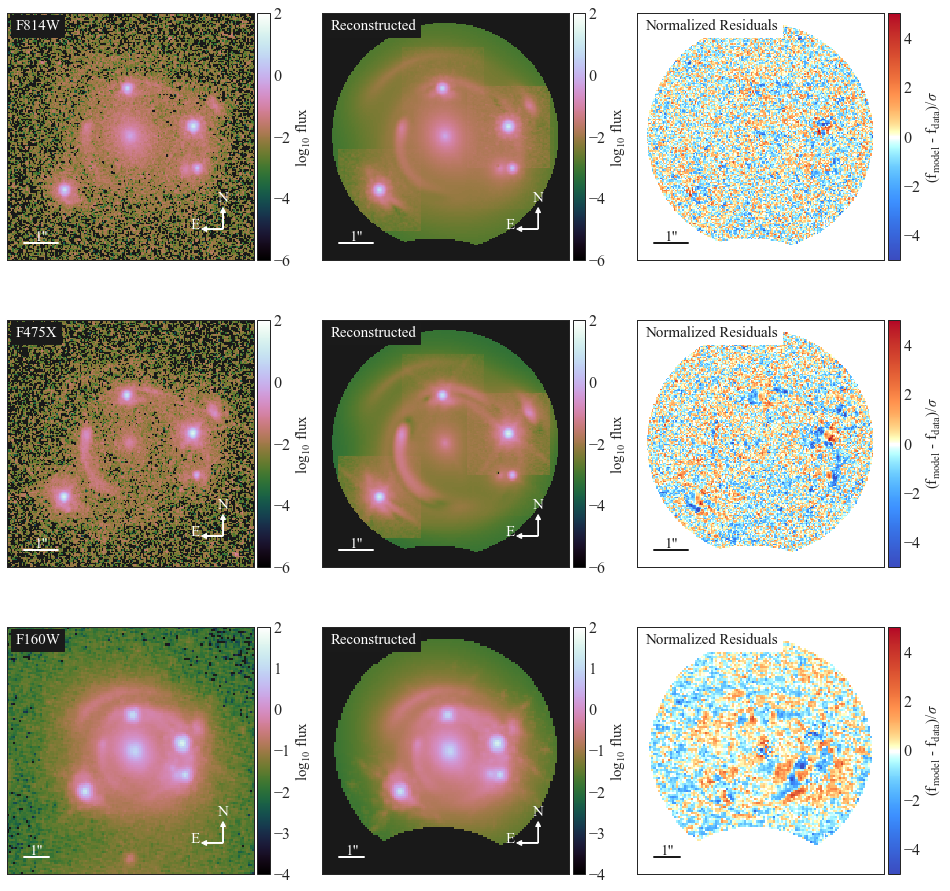

In [76]:
lens_plot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string=cmap,
                    likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'],
                    multi_band_type='multi-linear'#, source_marg=True, linear_prior=[1e5, 1e5, 1e5]
                    )

f, axes = plt.subplots(3, 3, figsize=(16, 16), sharex=False, sharey=False)

lens_plot.data_plot(ax=axes[0, 0], band_index=0, v_max= 2, v_min=-6, text='F814W')
lens_plot.data_plot(ax=axes[1, 0], band_index=1, v_max= 2, v_min=-6, text='F475X')
lens_plot.data_plot(ax=axes[2, 0], band_index=2, v_max= 2, v_min=-4, text='F160W')

lens_plot.model_plot(ax=axes[0, 1], band_index=0, v_max= 2, v_min=-6)
lens_plot.model_plot(ax=axes[1, 1], band_index=1, v_max= 2, v_min=-6)
lens_plot.model_plot(ax=axes[2, 1], band_index=2, v_max= 2, v_min=-4)

lens_plot.normalized_residual_plot(ax=axes[0, 2], band_index=0, v_max=5, v_min=-5, cmap=msh_cmap)
lens_plot.normalized_residual_plot(ax=axes[1, 2], band_index=1, v_max=5, v_min=-5, cmap=msh_cmap)
lens_plot.normalized_residual_plot(ax=axes[2, 2], band_index=2, v_max=5, v_min=-5, cmap=msh_cmap)

plt.show()

-1.1732763284880525 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.17503609243961
reduced chi^2 of data  1 =  1.2831200235760145
reduced chi^2 of data  2 =  0.894399755988298


/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/637825833.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_97241/637825833.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


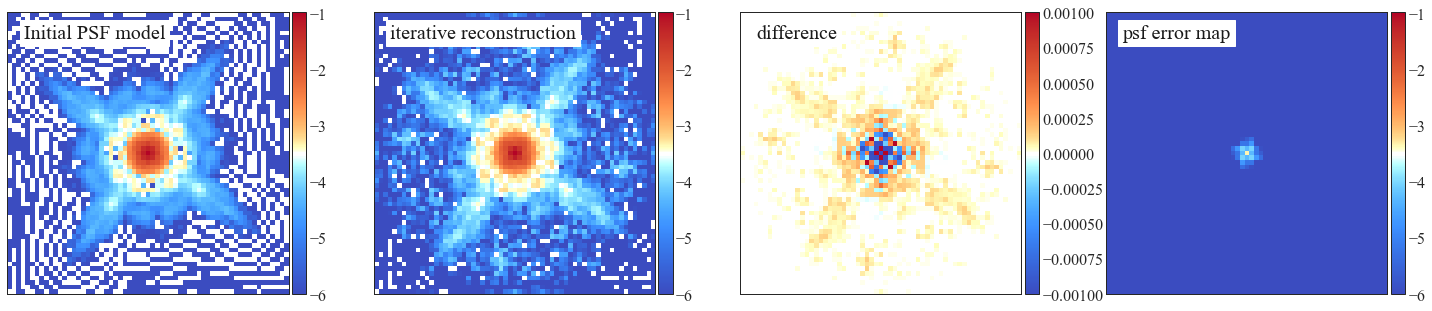

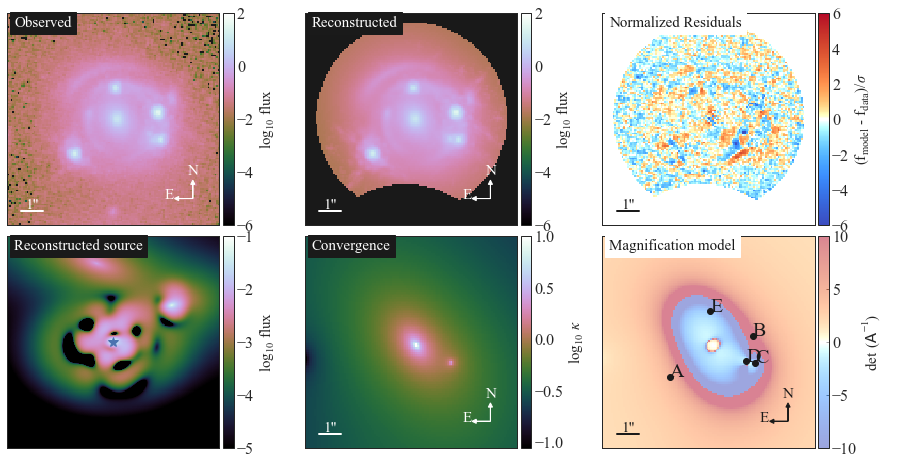

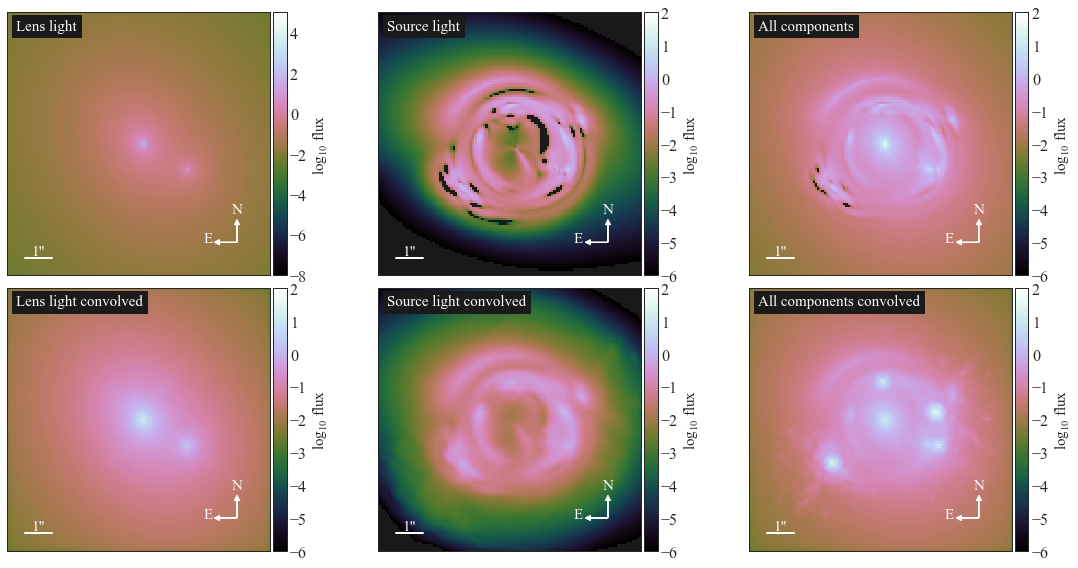

lens [{'theta_E': 1.794928277133542, 'gamma': 1.7457916574073091, 'e1': -0.08181057635421232, 'e2': 0.18872061788801045, 'center_x': -0.012558474540453123, 'center_y': -0.1541855040629432}, {'gamma_ext': 0.05893278393815402, 'psi_ext': 1.0426260503036155, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.15441245400283363, 'center_x': -1.5784457823921965, 'center_y': -0.9478411808067807}, {'theta_E': 0.40616563835745867, 'center_x': 1.0839901104658902, 'center_y': -6.516121582054507}, {'theta_E': 0.10144687506614838, 'center_x': -0.39902264938181325, 'center_y': -13.577953376770608}, {'theta_E': -0.17995458602883774, 'center_x': 5.342383555962899, 'center_y': -0.7750999830473467}, {'theta_E': 0.2962156279762601, 'center_x': 10.900788854734145, 'center_y': 5.532826990356399}, {'theta_E': -0.00033396631272993087, 'center_x': -0.3241539154260955, 'center_y': -0.41026490166902974}] 

 source [{'amp': 2.0735784982854812, 'R_sersic': 0.14703821925626898, 'n_sersic': 1.0, 'e1': 0.16079990770583413, 'e2':

In [81]:
if analyse_output:
    band_i = 2
    
    lensPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result_old, 
                         arrow_size=0.02, cmap_string=cmap,
                        likelihood_mask_list=mask_list[0], #kwargs_likelihood['image_likelihood_mask_list'],
                        multi_band_type='multi-linear'
                        )

    kwargs_psf = multi_band_list_out[band_i][1]
    
    from lenstronomy.Plots import chain_plot
    f, axes = chain_plot.psf_iteration_compare(kwargs_psf, vmin=-6, cmap=msh_cmap)
    f.show()
    
    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)
    
    lensPlot.data_plot(ax=axes[0,0], band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.model_plot(ax=axes[0,1], band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, band_index=band_i, cmap=msh_cmap)
    lensPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=200, band_index=band_i, v_min=-5, v_max=-1) 
    lensPlot.convergence_plot(ax=axes[1, 1], v_max=1, band_index=band_i)
    lensPlot.magnification_plot(ax=axes[1, 2], cmap=msh_cmap, band_index=band_i)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()

    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True, cmap=cmap, band_index=band_i, v_min=-8, v_max=5) 
    lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True, band_index=band_i, v_min=-6, v_max=2) 
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    
    lens_result, source_result, lens_light_result, ps_result = kwargs_result['kwargs_lens'], kwargs_result['kwargs_source'], kwargs_result['kwargs_lens_light'], kwargs_result['kwargs_ps']
    print('lens', lens_result, "\n\n source", source_result, '\n\n lens light', lens_light_result, '\n\n ps', ps_result)


In [46]:
import time
    
if fit_output[-1][0] == 'EMCEE':
    samples_mcmc = fit_output[-1][1]
else:
    samples_mcmc = []

if not samples_mcmc == []:
    #samples_mcmc = np.array(samples_mcmc)
    n_params = samples_mcmc.shape[1]

    n_walkers = 8 * n_params
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print(n_step, n_walkers, n_params)

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))
    
    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [#lens_name, 
                   median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                   median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2
                  ]


    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))
       
        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        #fig.tight_layout()
        plt.show()